# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
#warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", category=DeprecationWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn 

import sqlite3
import pandas as pd
import numpy as np
import math

from nltk.tokenize import RegexpTokenizer


np.seterr(divide='ignore', invalid='ignore')
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

import gensim
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Import the Imputer module
from sklearn.preprocessing import Imputer

# Classification metrics
from sklearn.metrics import roc_curve, auc

# Import confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import TruncatedSVD

from matplotlib      import pyplot as plt
from IPython.display import display

from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import FunctionTransformer

stop_words = set(stopwords.words('english'))

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LogisticRegression
from scipy.sparse import find

from sklearn.model_selection import RandomizedSearchCV

In [2]:
# using the SQLite Table to read data.
#con = sqlite3.connect('../input/database.sqlite') 

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
filtered_data_positive = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score > 3 ORDER BY RANDOM() LIMIT 50000 """, con) 
filtered_data_negative = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score < 3 ORDER BY RANDOM() LIMIT 50000 """, con) 

In [3]:
frames = [filtered_data_positive, filtered_data_negative]
filtered_data = pd.concat(frames)
filtered_data.shape

(100000, 10)

In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [5]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,238820,B000O5DI3W,AL3P8NCMOOEIH,Stephen Lurie,0,0,positive,1351123200,Pill Pockets,Our dog loves them and she is kind of a picky ...
1,138497,B0089SPENI,ANSYUEKO8HBEP,ann,0,0,positive,1350691200,great tea,this tea is wonderfully spicy. great on a col...
2,214325,B000M2PSDU,AAGEP9MCQMDR5,Christopher Gibson,6,6,positive,1198540800,One of the Best Hippos,Happy hippos are one of the best cookie/candie...
3,271282,B00176FUVK,A283EY4GNRTQR4,W,1,1,positive,1310256000,Favorite Treat for My Westies!,These are the favorite treats for my two Westi...
4,392592,B000JVAC30,A2SXF6F5EOL2CA,BeckySA,0,0,positive,1318809600,glaceau vitamin water,This product is not avail at my local store an...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(83122, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

83.122

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(83122, 10)


positive    45680
negative    37442
Name: Score, dtype: int64

In [13]:
print(final['Score'].head())
print(type(final['Score']))

16089    positive
65       negative
22817    positive
3836     positive
10900    positive
Name: Score, dtype: object
<class 'pandas.core.series.Series'>


## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        #print(i)
        #print(sent)
        break;
    i += 1;

In [15]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'of', 'be', "it's", 'those', 'ma', "haven't", 'so', "wasn't", 'won', 'themselves', 'is', 'through', 'does', 'no', 'doesn', 'by', 'a', 'i', "shan't", 'why', 'some', 'hasn', 'or', "wouldn't", 'them', 'once', 'couldn', 'shan', 'when', "mightn't", 'didn', 'will', "needn't", 'you', "hadn't", 'before', 'mustn', 'under', 'had', 'an', "isn't", 'what', 'mightn', 'her', 'aren', 'few', 'don', 'wasn', 'himself', 'y', 'during', "that'll", 'myself', 'doing', 'to', 'than', 'it', 'were', 'very', 'these', 'll', 'wouldn', 'out', 'into', 'not', "won't", 'can', 'against', 'after', "mustn't", 'own', 'about', 'him', 'are', 'weren', 'the', 'such', 'with', 'o', 'from', 'ours', 'we', 'he', 'd', "weren't", "hasn't", 'am', 'now', 'any', "didn't", 'same', 'has', "you've", 'as', 'my', 'theirs', 'who', "you're", 'been', 'until', 'being', 'if', 'on', 'there', 'they', 'how', 'having', 'where', 'for', 'over', 'have', 'yourself', 'more', 'too', "don't", 'should', 'that', "doesn't", 's', 've', 'whom', 'up', 'herself', 

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [18]:
final.head()
final.shape

(83122, 11)

In [19]:
print("TEXT PROCESSIONG COMPLETED")

TEXT PROCESSIONG COMPLETED


**TRAIN TEST SPLIT**

In [20]:
#TRAIN TEST SPIT
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3
                                                    ,shuffle=False,random_state=60)

#X_train, X_test, y_train, y_test = train_test_split(final_input['CleanedText'].values,final_input['Score'].values,test_size=0.3
 #                                                  ,shuffle=False,random_state=60)

print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape)
X_train[0:2]


Test Data Size:  (24937,)
Train Data Size:  (58185,)


array(['ive alway love chicken soup rice late ethel alway made homemad chicken chicken soup rice book take back day mother father sister went ethel hous late isador would cook chicken ethel blind remind time togeth famili bring back happi memori love share bowl hot soup',
       'one best children book ever written mini version book portray one price product sent email regard bewilder amazon got respons'],
      dtype=object)

In [21]:
#column_cleaned_text(X_train[0:3])
#y_test

In [22]:
print("BOW STARTED:")

BOW STARTED:


**Bag of Words (BoW)**

In [23]:
pipelines_bow_logisticreg = Pipeline([
    ('countvect',CountVectorizer()),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression()),
])

In [24]:
# List tuneable hyperparameters of our  pipeline
pipelines_bow_logisticreg.get_params()

{'memory': None,
 'steps': [('countvect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=None, vocabulary=None)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'countvect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, 

In [25]:
pipelines_bow_logisticreg.get_params().keys()

dict_keys(['memory', 'steps', 'countvect', 'normalizer', 'logisticreg', 'countvect__analyzer', 'countvect__binary', 'countvect__decode_error', 'countvect__dtype', 'countvect__encoding', 'countvect__input', 'countvect__lowercase', 'countvect__max_df', 'countvect__max_features', 'countvect__min_df', 'countvect__ngram_range', 'countvect__preprocessor', 'countvect__stop_words', 'countvect__strip_accents', 'countvect__token_pattern', 'countvect__tokenizer', 'countvect__vocabulary', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [26]:
hyperparameters_bow_logisticreg = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [27]:
# Example for TImeseries Split
tss = TimeSeriesSplit(n_splits=3)
for train, cv in tss.split(X_train):
    #print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)   

(14547,) (14546,)
(29093,) (14546,)
(43639,) (14546,)


**BOW - LogisticRegression Search using Grid Search **

In [28]:
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting

In [29]:
print("BOW MultinomialNB - GRID SEARCH STARTED:")

BOW MultinomialNB - GRID SEARCH STARTED:


In [30]:
model_bow_logisticreg = GridSearchCV(pipelines_bow_logisticreg, hyperparameters_bow_logisticreg, cv=tscv, n_jobs=1,verbose=1)

In [31]:
model_bow_logisticreg.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  6.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [32]:
#print("Best Estimator for BOW MultinomialNB",model_bow_MultinomialNB.best_estimator_)
print("Best Score for BOW model_bow_logisticreg",model_bow_logisticreg.best_score_)
print("Best Parms for BOW model_bow_logisticreg",model_bow_logisticreg.best_params_)

Best Score for BOW model_bow_logisticreg 0.8671112333287502
Best Parms for BOW model_bow_logisticreg {'logisticreg__C': 5, 'logisticreg__penalty': 'l2'}


In [33]:
# coefficients are in the best_estimator_ attribute
coef_bow_logisticreg = model_bow_logisticreg.best_estimator_.get_params()['logisticreg'].coef_
print(coef_bow_logisticreg)
print(model_bow_logisticreg.best_estimator_.get_params()['logisticreg'].coef_[0])

[[-0.02671339  0.00706505 -0.05867203 ... -0.06740738  0.1275107
   0.03157754]]
[-0.02671339  0.00706505 -0.05867203 ... -0.06740738  0.1275107
  0.03157754]


In [34]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):
    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_
    print(type(cv_results))

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())
        # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]
    
    # display the top 'num_results' results
    # =====================================
   # display(pd.DataFrame(cv_results).sort_values(by='rank_test_score').head(num_results))
# plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)       
    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]
    
    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

<class 'sklearn.utils.deprecation.DeprecationDict'>
best parameters: {'logisticreg__C': 5, 'logisticreg__penalty': 'l2'}
best score:      0.86711 (+/-0.00156)
{'countvect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None),
 'countvect__analyzer': 'word',
 'countvect__binary': False,
 'countvect__decode_error': 'strict',
 'countvect__dtype': <class 'numpy.int64'>,
 'countvect__encoding': 'utf-8',
 'countvect__input': 'content',
 'countvect__lowercase': True,
 'countvect__max_df': 1.0,
 'countvect__max_features': None,
 'countvect__min_df': 1,
 'countvect__ngram_range': (1, 1),
 'countvect__preprocessor': None,
 'countvect__stop_words': None,
 'countvect__strip_accent

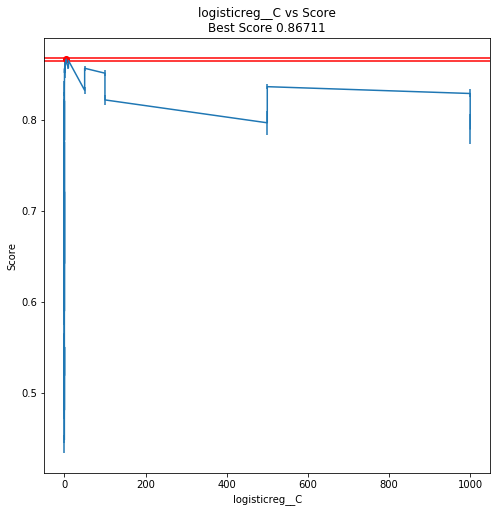

In [35]:
GridSearch_table_plot(model_bow_logisticreg, "logisticreg__C"
                      , negative=False)

In [36]:
def plot_error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['logisticreg__penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['logisticreg__C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['logisticreg__C'])

    
    print(x1)
    print(y1)
    

    
    #plt.figure(figsize=(8, 8))
    plt.xlim(-10,1010)
    plt.ylim(0,0.4)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'g',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()

[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
[0.209473394747697, 0.20280489481644437, 0.17764333837481094, 0.1670791511984967, 0.14216966863742608, 0.1367615381089876, 0.13955726660250245, 0.14780695723910353, 0.19171364407168068, 0.221985425546542, 0.3576240890966589, 0.4098492139878088, 0.4808423850772263, 0.5186534671616481, 0.5506897658004491]


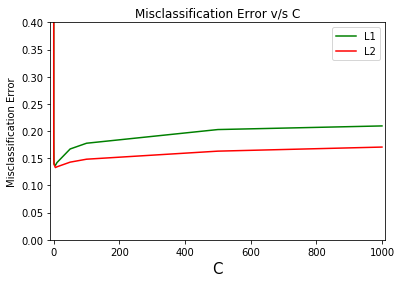

In [37]:
plot_error_vs_c(model_bow_logisticreg)

In [38]:
model_bow_logisticreg.grid_scores_

[mean: 0.79053, std: 0.01613, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l1'},
 mean: 0.82941, std: 0.00440, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l2'},
 mean: 0.79720, std: 0.01306, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l1'},
 mean: 0.83691, std: 0.00303, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l2'},
 mean: 0.82236, std: 0.00505, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l1'},
 mean: 0.85173, std: 0.00357, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l2'},
 mean: 0.83292, std: 0.00363, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l1'},
 mean: 0.85714, std: 0.00247, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l2'},
 mean: 0.85783, std: 0.00143, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l1'},
 mean: 0.86569, std: 0.00267, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l2'},
 mean: 0.86324, std: 0.00122, params: {'logisticreg__C': 5, 'logisticreg

In [39]:
# Predict classes using  
pred = model_bow_logisticreg.predict(X_test)
# Display first 5 predictions
pred[:10]

array(['negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive'],
      dtype=object)

In [40]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_bow_grid = accuracy_score(y_test, pred, normalize=True) * 100
print('Accuracy of the {} model on unseen data is {} %'.format("BOW: ", np.round(test_accuracy_bow_grid,2)))

Accuracy of the BOW:  model on unseen data is 87.86 %


In [41]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9821  1442]
 [ 1586 12088]]


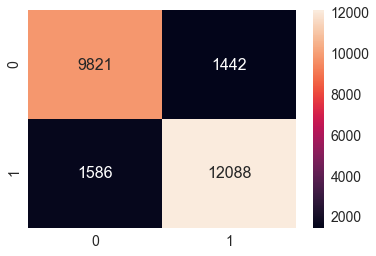

In [42]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [43]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.86      0.87      0.87     11263
   positive       0.89      0.88      0.89     13674

avg / total       0.88      0.88      0.88     24937



*** TOP POSITIVE AND NEGATIVE WORDS  ***

In [44]:
feature_names=model_bow_logisticreg.best_estimator_.get_params()['countvect'].get_feature_names()
feature_names[0:5]

['aaa', 'aaaa', 'aaaaaaarrrrrggghhh', 'aaaaaah', 'aaahhh']

In [45]:
coef_bow_logisticreg = model_bow_logisticreg.best_estimator_.get_params()['logisticreg'].coef_[0]
coef_bow_logisticreg

array([-0.02671339,  0.00706505, -0.05867203, ..., -0.06740738,
        0.1275107 ,  0.03157754])

In [46]:
coefs_with_fns = sorted(zip(coef_bow_logisticreg, feature_names))

In [47]:
n=20
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
top

In [48]:
print("\t\t\tNegative \t\t\t\t\t\Positive")
print("________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative 					\Positive
________________________________________________________________________________________________
	-14.0527	worst          				9.2412	perfect        
	-9.9972	horribl        				8.8332	delici         
	-9.9279	terribl        				8.3706	awesom         
	-9.9055	disappoint     				8.0919	excel          
	-9.6926	aw             				7.7721	addict         
	-8.3822	unfortun       				7.7442	beat           
	-8.3245	threw          				7.5530	amaz           
	-8.3094	stale          				7.4924	best           
	-8.2844	tasteless      				7.1512	yummi          
	-8.2436	gross          				7.1161	great          
	-8.2278	bland          				7.1032	fantast        
	-8.0919	sad            				7.0246	skeptic        
	-7.8713	poor           				7.0096	hook           
	-7.8493	disgust        				6.7532	worri          
	-7.6853	yuck           				6.4281	satisfi        
	-7.3485	unpleas        				6.3330	uniqu          
	-7.3403	return         				6.0087	outstand       
	-7.0901

In [49]:
def show_most_informative_features(model, countvect_pipe,logireg_pipe, n=25):
    feature_names=model.best_estimator_.get_params()[countvect_pipe].get_feature_names()
    coef_bow_logisticreg = model.best_estimator_.get_params()[logireg_pipe].coef_[0]
    coefs_with_fns = sorted(zip(coef_bow_logisticreg, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative \t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        

In [50]:
show_most_informative_features(model_bow_logisticreg,'countvect','logisticreg')

			Negative 						Positive
________________________________________________________________________________________________
	-14.0527	worst          				9.2412	perfect        
	-9.9972	horribl        				8.8332	delici         
	-9.9279	terribl        				8.3706	awesom         
	-9.9055	disappoint     				8.0919	excel          
	-9.6926	aw             				7.7721	addict         
	-8.3822	unfortun       				7.7442	beat           
	-8.3245	threw          				7.5530	amaz           
	-8.3094	stale          				7.4924	best           
	-8.2844	tasteless      				7.1512	yummi          
	-8.2436	gross          				7.1161	great          
	-8.2278	bland          				7.1032	fantast        
	-8.0919	sad            				7.0246	skeptic        
	-7.8713	poor           				7.0096	hook           
	-7.8493	disgust        				6.7532	worri          
	-7.6853	yuck           				6.4281	satisfi        
	-7.3485	unpleas        				6.3330	uniqu          
	-7.3403	return         				6.0087	outstand       
	-7.0901

***For L1 Regularizer,As C decreases(or Lambda increases), Sparsity increases***

In [51]:
pipelines_bow_logisticreg_sparse = Pipeline([
    ('countvect',CountVectorizer()),
    ('normalizer', preprocessing.Normalizer()),
    ('logreg',LogisticRegression(C= 1000, penalty= 'l1'))
])

pipelines_bow_logisticreg_sparse.fit(X_train, y_train)
y_pred = pipelines_bow_logisticreg_sparse.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
coef_bow_logisticreg_sparse = pipelines_bow_logisticreg_sparse.named_steps['logreg'].coef_
print("Non Zero weights:",np.count_nonzero(coef_bow_logisticreg_sparse))

Accuracy on test set: 80.804%
Non Zero weights: 16407


In [52]:
pipelines_bow_logisticreg_sparse = Pipeline([
    ('countvect',CountVectorizer()),
    ('normalizer', preprocessing.Normalizer()),
    ('logreg',LogisticRegression(C= 100, penalty= 'l1'))
])

pipelines_bow_logisticreg_sparse.fit(X_train, y_train)
y_pred = pipelines_bow_logisticreg_sparse.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
coef_bow_logisticreg_sparse = pipelines_bow_logisticreg_sparse.named_steps['logreg'].coef_
print("Non Zero weights:",np.count_nonzero(coef_bow_logisticreg_sparse))

Accuracy on test set: 83.603%
Non Zero weights: 12864


In [53]:
pipelines_bow_logisticreg_sparse = Pipeline([
    ('countvect',CountVectorizer()),
    ('normalizer', preprocessing.Normalizer()),
    ('logreg',LogisticRegression(C= 10, penalty= 'l1'))
])

pipelines_bow_logisticreg_sparse.fit(X_train, y_train)
y_pred = pipelines_bow_logisticreg_sparse.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
coef_bow_logisticreg_sparse = pipelines_bow_logisticreg_sparse.named_steps['logreg'].coef_
print("Non Zero weights:",np.count_nonzero(coef_bow_logisticreg_sparse))

Accuracy on test set: 87.124%
Non Zero weights: 6193


In [54]:
pipelines_bow_logisticreg_sparse = Pipeline([
    ('countvect',CountVectorizer()),
    ('normalizer', preprocessing.Normalizer()),
    ('logreg',LogisticRegression(C= 1, penalty= 'l1'))
])

pipelines_bow_logisticreg_sparse.fit(X_train, y_train)
y_pred = pipelines_bow_logisticreg_sparse.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
coef_bow_logisticreg_sparse = pipelines_bow_logisticreg_sparse.named_steps['logreg'].coef_
print("Non Zero weights:",np.count_nonzero(coef_bow_logisticreg_sparse))

Accuracy on test set: 87.501%
Non Zero weights: 1303


***Randomized Search  ***

In [55]:
#TRAIN TEST SPIT
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3
                                                    ,shuffle=False,random_state=60)

#X_train, X_test, y_train, y_test = train_test_split(final_input['CleanedText'].values,final_input['Score'].values,test_size=0.3
 #                                                  ,shuffle=False,random_state=60)

print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape)
X_train[0:2]

Test Data Size:  (24937,)
Train Data Size:  (58185,)


array(['ive alway love chicken soup rice late ethel alway made homemad chicken chicken soup rice book take back day mother father sister went ethel hous late isador would cook chicken ethel blind remind time togeth famili bring back happi memori love share bowl hot soup',
       'one best children book ever written mini version book portray one price product sent email regard bewilder amazon got respons'],
      dtype=object)

In [56]:
print(type(X_train))
print(type(X_test))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [57]:
pipelines_bow_logisticreg_random = Pipeline([
    ('countvect',CountVectorizer()),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression())
])

In [58]:
# List tuneable hyperparameters of our  pipeline
pipelines_bow_logisticreg_random.get_params()

{'memory': None,
 'steps': [('countvect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=None, vocabulary=None)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'countvect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, 

In [59]:
pipelines_bow_logisticreg_random.get_params().keys()

dict_keys(['memory', 'steps', 'countvect', 'normalizer', 'logisticreg', 'countvect__analyzer', 'countvect__binary', 'countvect__decode_error', 'countvect__dtype', 'countvect__encoding', 'countvect__input', 'countvect__lowercase', 'countvect__max_df', 'countvect__max_features', 'countvect__min_df', 'countvect__ngram_range', 'countvect__preprocessor', 'countvect__stop_words', 'countvect__strip_accents', 'countvect__token_pattern', 'countvect__tokenizer', 'countvect__vocabulary', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [60]:
hyperparameters_bow_logisticreg_random = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [61]:
#RandomizedSearchCV
# Example for TImeseries Split
tss = TimeSeriesSplit(n_splits=3)
for train, cv in tss.split(X_train):
    #print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)   

(14547,) (14546,)
(29093,) (14546,)
(43639,) (14546,)


In [62]:
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting

In [63]:
print("BOW LOGI REG - RANDOM SEARCH STARTED:")

BOW LOGI REG - RANDOM SEARCH STARTED:


https://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv

In [64]:
model_bow_logisticreg_random = RandomizedSearchCV(pipelines_bow_logisticreg_random,
                                                  hyperparameters_bow_logisticreg_random, cv=tscv, n_jobs=1,verbose=1)

#n_iter_search = 2 # Define number of search iterations
#model_bow_logisticreg_random = RandomizedSearchCV(pipelines_bow_logisticreg_random, 
 #                                                 param_distributions=hyperparameters_bow_logisticreg_random,return_train_score=False, 
 #                                                 n_iter=n_iter_search, cv=tscv, n_jobs=1, verbose=1)

In [65]:
model_bow_logisticreg_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.9min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('countvect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [66]:
print("Best Score for BOW model_bow_logisticreg",model_bow_logisticreg_random.best_score_)
print("Best Parms for BOW model_bow_logisticreg",model_bow_logisticreg_random.best_params_)

Best Score for BOW model_bow_logisticreg 0.8671112333287502
Best Parms for BOW model_bow_logisticreg {'logisticreg__penalty': 'l2', 'logisticreg__C': 5}


In [67]:
# coefficients are in the best_estimator_ attribute
coef_bow_logisticreg_random = model_bow_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_
print(coef_bow_logisticreg_random)
print(model_bow_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_[0])

[[-0.02671339  0.00706505 -0.05867203 ... -0.06740738  0.1275107
   0.03157754]]
[-0.02671339  0.00706505 -0.05867203 ... -0.06740738  0.1275107
  0.03157754]


In [68]:
# Predict classes using  
pred = model_bow_logisticreg_random.predict(X_test)
pred[0:5]

array(['negative', 'negative', 'negative', 'positive', 'negative'],
      dtype=object)

In [69]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_bow_random = accuracy_score(y_test, pred, normalize=True) * 100
print('Accuracy of the {} model on unseen data is {} %'.format("BOW Log Reg", np.round(test_accuracy_bow_random,2)))

Accuracy of the BOW Log Reg model on unseen data is 87.86 %


In [70]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9821  1442]
 [ 1586 12088]]


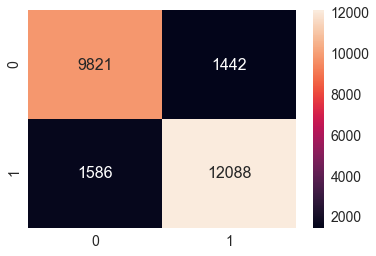

In [71]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [72]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.86      0.87      0.87     11263
   positive       0.89      0.88      0.89     13674

avg / total       0.88      0.88      0.88     24937



***ROC CURVE - BOW - LOG REG***

In [73]:
# Predict classes using bOW Log Reg 
pred_prob = model_bow_logisticreg_random.predict_proba(X_test)
# Display first 5 predictions
pred_prob[:10]

array([[9.98671309e-01, 1.32869064e-03],
       [8.86021096e-01, 1.13978904e-01],
       [9.01396210e-01, 9.86037900e-02],
       [2.52794662e-01, 7.47205338e-01],
       [9.18597386e-01, 8.14026142e-02],
       [6.55252349e-01, 3.44747651e-01],
       [9.60302639e-01, 3.96973609e-02],
       [8.88602363e-01, 1.11397637e-01],
       [9.99966565e-01, 3.34354162e-05],
       [2.85281455e-02, 9.71471855e-01]])

In [74]:
#fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:, 1])
y_test[0:10]

array(['negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive'],
      dtype=object)

In [75]:
y_test_binary=np.where(y_test=="positive",1,0)

In [76]:
#fpr, tpr, thresholds = roc_curve(y_test_NB,Y_score[:, 1])
fpr, tpr, thresholds = roc_curve(y_test_binary,pred_prob[:, 1])

In [77]:
roc_auc = auc(fpr, tpr)

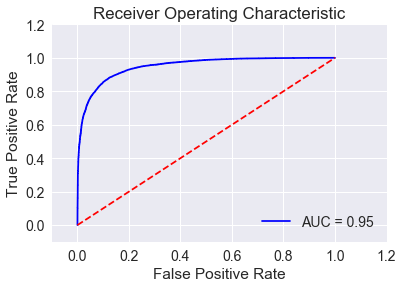

In [78]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

***Perturbation Test***

In [79]:
#Text -> Uni gram Vectors
countvect = CountVectorizer() 
X_train_countvect_pert = countvect.fit_transform(X_train)
#Normalize Data
X_train_normalize_pert = preprocessing.normalize(X_train_countvect_pert)
print("Train Data Size: ",X_train.shape)
X_test_countvect_pert = countvect.transform(X_test)
#Normalize Data
X_test_normalize_pert = preprocessing.normalize(X_test_countvect_pert)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (58185,)
Test Data Size:  (24937,)


In [80]:
clf_pert = LogisticRegression(C= 5, penalty= 'l2')
clf_pert.fit(X_train_normalize_pert,y_train)
y_pred_pert = clf_pert.predict(X_test_normalize_pert)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_pert)*100))
print("Non Zero weights:",np.count_nonzero(clf_pert.coef_))

Accuracy on test set: 87.857%
Non Zero weights: 29492


In [81]:
#Weights before adding random noise
weights_pert_before_noise = find(clf_pert.coef_[0])[2]
print(weights_pert_before_noise[:10])

[-0.02671339  0.00706505 -0.05867203  0.00461596  0.07744356 -0.16395641
  0.00677687  0.46145417  0.19345833  0.02143432]


In [82]:
X_train_noise = X_train_normalize_pert
#Random noise
noise = np.random.uniform(low=-0.001, high=0.001, size=(find(X_train_noise)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_noise)

#Introducing random noise to non-zero datapoints
X_train_noise[a,b] = noise + X_train_noise[a,b]

In [83]:
X_train_normalize_pert.shape

(58185, 29492)

In [84]:
print(find(X_train_noise))
print(len(find(X_train_noise)))
print(find(X_train_noise)[0])
print(len(find(X_train_noise)[0]))
print(find(X_train_noise)[0].size)

(array([23186, 30857, 44763, ..., 38349,   482,  3308], dtype=int32), array([    0,     1,     2, ..., 29489, 29490, 29491], dtype=int32), array([0.10894737, 0.17159635, 0.07848271, ..., 0.16845035, 0.09762685,
       0.16934061]))
3
[23186 30857 44763 ... 38349   482  3308]
1836896
1836896


In [85]:
#print(a)
#print(b)
#print(c)
#print(noise.shape)
#print(noise[0])
#print(X_train_noise[a,b].shape)
#print(X_train_noise[a,b][0])
#print(X_train_noise_added.shape)

In [86]:
#Training on train data having random noise

clf_pert_after_noise = LogisticRegression(C= 5, penalty= 'l2')
clf_pert_after_noise.fit(X_train_noise,y_train)
y_pred_after_noise = clf_pert_after_noise.predict(X_test_normalize_pert)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf_pert_after_noise.coef_))

Accuracy on test set: 87.501%
Non Zero weights: 29492


In [87]:
#Weights after adding random noise
weights_after_noise = find(clf_pert_after_noise.coef_[0])[2]
print(weights_after_noise[:50])

[-0.02686878  0.00705815 -0.05841487  0.00468045  0.07730291 -0.16286909
  0.00665954  0.46243565  0.19169491  0.02154588  0.04851904 -0.01258736
 -0.01822397 -0.01803102 -0.26701203 -0.32909772  0.01788842  0.82330013
 -0.28853211  0.11844437 -0.03706457  0.34657771 -0.00728166  0.38224214
  0.59829065  0.63532999 -0.18883882 -0.34103967 -0.01051245  0.1435319
 -0.89665528 -0.09551631 -0.02402361 -0.04073784 -0.34536828 -0.0141393
 -0.00952377  1.78282109 -0.25060187  0.01434191  0.87829807  0.16486982
 -0.66902096  0.0139456   0.1934126   0.08787185 -0.07522127 -1.22661224
  0.06937566 -0.23856463]


In [88]:
print(weights_pert_before_noise.size)
print(weights_after_noise.size)

29492
29492


In [89]:
weights_diff = (abs(weights_pert_before_noise - weights_after_noise)/weights_pert_before_noise) * 100

In [90]:
print(weights_diff[np.where(weights_diff > 30)].size)

61


***Observation:-***

***As per above only 61 weights(0.2%) have weight difference before and after adding noise greater than 30%. So features are not multicollinear and feature weights can be used for feaature importance. ***

** TFIDF - LOG REGRESSION  **

**TRAIN TEST SPLIT**

In [91]:
#TRAIN TEST SPIT
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3
                                                    ,shuffle=False,random_state=60)

#X_train, X_test, y_train, y_test = train_test_split(final_input['CleanedText'].values,final_input['Score'].values,test_size=0.3
 #                                                  ,shuffle=False,random_state=60)

print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape)
X_train[0:2]

Test Data Size:  (24937,)
Train Data Size:  (58185,)


array(['ive alway love chicken soup rice late ethel alway made homemad chicken chicken soup rice book take back day mother father sister went ethel hous late isador would cook chicken ethel blind remind time togeth famili bring back happi memori love share bowl hot soup',
       'one best children book ever written mini version book portray one price product sent email regard bewilder amazon got respons'],
      dtype=object)

In [92]:
print("TFIDF STARTED:")

TFIDF STARTED:


**TFIDF**

In [93]:
pipelines_tfidf_logisticreg = Pipeline([
    ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression()),
])

In [94]:
# List tuneable hyperparameters of our  pipeline
pipelines_tfidf_logisticreg.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='c

In [95]:
pipelines_tfidf_logisticreg.get_params().keys()

dict_keys(['memory', 'steps', 'tfidf', 'normalizer', 'logisticreg', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [96]:
hyperparameters_tfidf_logisticreg = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [97]:
# Example for TImeseries Split
tss = TimeSeriesSplit(n_splits=3)
for train, cv in tss.split(X_train):
    #print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)   

(14547,) (14546,)
(29093,) (14546,)
(43639,) (14546,)


**TF-IDF - Log Reg using Grid Search **

In [98]:
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting

In [99]:
print("Log Reg TFIDF - GRID SEARCH STARTED:")

Log Reg TFIDF - GRID SEARCH STARTED:


In [100]:
model_tfidf_logisticreg = GridSearchCV(pipelines_tfidf_logisticreg, hyperparameters_tfidf_logisticreg, cv=tscv, n_jobs=1,verbose=1)

In [101]:
model_tfidf_logisticreg.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 15.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [102]:
#print("Best Estimator for BOW MultinomialNB",model_bow_MultinomialNB.best_estimator_)
print("Best Score for TFIDF model_bow_logisticreg",model_tfidf_logisticreg.best_score_)
print("Best Parms for TFIDF model_bow_logisticreg",model_tfidf_logisticreg.best_params_)

Best Score for TFIDF model_bow_logisticreg 0.883496035565333
Best Parms for TFIDF model_bow_logisticreg {'logisticreg__C': 1000, 'logisticreg__penalty': 'l2'}


In [103]:
# coefficients are in the best_estimator_ attribute
coef_tfidf_logisticreg = model_tfidf_logisticreg.best_estimator_.get_params()['logisticreg'].coef_
print(coef_tfidf_logisticreg)
print(model_tfidf_logisticreg.best_estimator_.get_params()['logisticreg'].coef_[0])

[[-0.03406517 -0.03406517  0.00359731 ... -0.00883552  0.61745616
   0.38092264]]
[-0.03406517 -0.03406517  0.00359731 ... -0.00883552  0.61745616
  0.38092264]


<class 'sklearn.utils.deprecation.DeprecationDict'>
best parameters: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l2'}
best score:      0.88350 (+/-0.00405)
{'logisticreg': LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
 'logisticreg__C': 1000,
 'logisticreg__class_weight': None,
 'logisticreg__dual': False,
 'logisticreg__fit_intercept': True,
 'logisticreg__intercept_scaling': 1,
 'logisticreg__max_iter': 100,
 'logisticreg__multi_class': 'ovr',
 'logisticreg__n_jobs': 1,
 'logisticreg__penalty': 'l2',
 'logisticreg__random_state': None,
 'logisticreg__solver': 'liblinear',
 'logisticreg__tol': 0.0001,
 'logisticreg__verbose': 0,
 'logisticreg__warm_start': False,
 'memory': None,
 'normalizer': Normalizer(copy=True, norm='l2'),
 'normalizer__copy': True,
 'norma

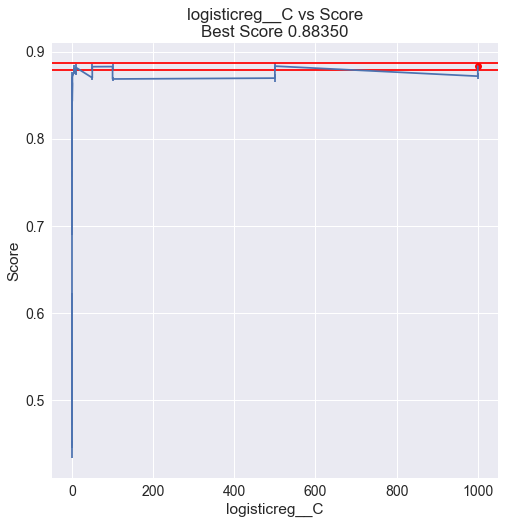

In [104]:
GridSearch_table_plot(model_tfidf_logisticreg, "logisticreg__C"
                      , negative=False)

[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
[0.12807644713323252, 0.13032219625097397, 0.13130757596590126, 0.12995554333379167, 0.1250973921811266, 0.12321829598056744, 0.13886979238278563, 0.15681286951739315, 0.2226041523442871, 0.2739355607498052, 0.44931023419955085, 0.44931023419955085, 0.4808423850772263, 0.5186534671616481, 0.5506897658004491]


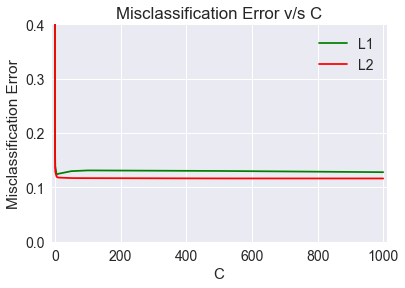

In [105]:
plot_error_vs_c(model_tfidf_logisticreg)

In [106]:
model_tfidf_logisticreg.grid_scores_

[mean: 0.87192, std: 0.00332, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l1'},
 mean: 0.88350, std: 0.00405, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l2'},
 mean: 0.86968, std: 0.00434, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l1'},
 mean: 0.88343, std: 0.00410, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l2'},
 mean: 0.86869, std: 0.00259, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l1'},
 mean: 0.88290, std: 0.00354, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l2'},
 mean: 0.87004, std: 0.00201, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l1'},
 mean: 0.88279, std: 0.00357, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l2'},
 mean: 0.87490, std: 0.00185, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l1'},
 mean: 0.88182, std: 0.00402, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l2'},
 mean: 0.87678, std: 0.00188, params: {'logisticreg__C': 5, 'logisticreg

In [107]:
# Predict classes using  
pred = model_tfidf_logisticreg.predict(X_test)
# Display first 5 predictions
pred[:10]

array(['negative', 'negative', 'negative', 'positive', 'negative',
       'positive', 'negative', 'negative', 'negative', 'positive'],
      dtype=object)

In [108]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_tfidf_grid = accuracy_score(y_test, pred, normalize=True) * 100
print('Accuracy of the {} model on unseen data is {} %'.format("TFIDF: ", np.round(test_accuracy_tfidf_grid,2)))

Accuracy of the TFIDF:  model on unseen data is 89.5 %


In [109]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9973  1290]
 [ 1329 12345]]


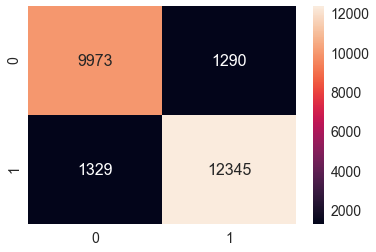

In [110]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [111]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.88      0.89      0.88     11263
   positive       0.91      0.90      0.90     13674

avg / total       0.90      0.89      0.89     24937



*** TOP POSITIVE AND NEGATIVE WORDS  ***

In [112]:
feature_names=model_tfidf_logisticreg.best_estimator_.get_params()['tfidf'].get_feature_names()
feature_names[0:5]

['aaa', 'aaa dont', 'aaaa', 'aaaaaaarrrrrggghhh', 'aaaaaaarrrrrggghhh back']

In [113]:
coef_tfidf_logisticreg = model_tfidf_logisticreg.best_estimator_.get_params()['logisticreg'].coef_[0]
coef_tfidf_logisticreg

array([-0.03406517, -0.03406517,  0.00359731, ..., -0.00883552,
        0.61745616,  0.38092264])

In [114]:
coefs_with_fns = sorted(zip(coef_tfidf_logisticreg, feature_names))

In [115]:
n=20
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
top

In [116]:
show_most_informative_features(model_tfidf_logisticreg,'tfidf','logisticreg')

			Negative 						Positive
________________________________________________________________________________________________
	-47.4781	disappoint     				44.3549	great          
	-37.6702	worst          				39.9850	love           
	-32.4442	terribl        				39.4718	delici         
	-30.2051	horribl        				38.2965	best           
	-30.1913	unfortun       				37.6131	perfect        
	-29.4857	aw             				33.0792	high recommend 
	-27.0498	stale          				30.4255	excel          
	-25.7764	return         				26.7135	awesom         
	-25.2020	bland          				25.1582	nice           
	-24.6553	wont buy       				24.5267	amaz           
	-23.6279	poor           				24.4416	favorit        
	-23.3696	two star       				23.9997	good           
	-23.0118	threw          				23.6335	addict         
	-22.0952	weak           				22.1716	yummi          
	-21.9914	tasteless      				22.1240	fantast        
	-21.7839	gross          				21.3696	easi           
	-21.6398	sad            			

***Randomized Search  ***

In [117]:
#TRAIN TEST SPIT
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3
                                                    ,shuffle=False,random_state=60)

#X_train, X_test, y_train, y_test = train_test_split(final_input['CleanedText'].values,final_input['Score'].values,test_size=0.3
 #                                                  ,shuffle=False,random_state=60)

print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape)
X_train[0:2]

Test Data Size:  (24937,)
Train Data Size:  (58185,)


array(['ive alway love chicken soup rice late ethel alway made homemad chicken chicken soup rice book take back day mother father sister went ethel hous late isador would cook chicken ethel blind remind time togeth famili bring back happi memori love share bowl hot soup',
       'one best children book ever written mini version book portray one price product sent email regard bewilder amazon got respons'],
      dtype=object)

In [118]:
pipelines_tfidf_logisticreg_random = Pipeline([
    ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression()),
])

In [119]:
# List tuneable hyperparameters of our  pipeline
pipelines_tfidf_logisticreg_random.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='c

In [120]:
pipelines_tfidf_logisticreg_random.get_params().keys()

dict_keys(['memory', 'steps', 'tfidf', 'normalizer', 'logisticreg', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [121]:
hyperparameters_tfidf_logisticreg_random = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [122]:
#RandomizedSearchCV
# Example for TImeseries Split
tss = TimeSeriesSplit(n_splits=3)
for train, cv in tss.split(X_train):
    #print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)   

(14547,) (14546,)
(29093,) (14546,)
(43639,) (14546,)


In [123]:
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting

In [124]:
print("TFIDF LOGI REG - RANDOM SEARCH STARTED:")

TFIDF LOGI REG - RANDOM SEARCH STARTED:


In [125]:
model_tfidf_logisticreg_random = RandomizedSearchCV(pipelines_tfidf_logisticreg_random,
                                                  hyperparameters_tfidf_logisticreg_random, cv=tscv, n_jobs=1,verbose=1)

In [126]:
model_tfidf_logisticreg_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [127]:
print("Best Score for BOW model_bow_logisticreg",model_tfidf_logisticreg_random.best_score_)
print("Best Parms for BOW model_bow_logisticreg",model_tfidf_logisticreg_random.best_params_)

Best Score for BOW model_bow_logisticreg 0.883496035565333
Best Parms for BOW model_bow_logisticreg {'logisticreg__penalty': 'l2', 'logisticreg__C': 1000}


In [128]:
# coefficients are in the best_estimator_ attribute
coef_tfidf_logisticreg_random = model_tfidf_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_
print(coef_tfidf_logisticreg_random)
print(model_tfidf_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_[0])

[[-0.03406517 -0.03406517  0.00359731 ... -0.00883552  0.61745616
   0.38092264]]
[-0.03406517 -0.03406517  0.00359731 ... -0.00883552  0.61745616
  0.38092264]


In [129]:
# Predict classes using  
pred = model_tfidf_logisticreg_random.predict(X_test)
pred[0:5]

array(['negative', 'negative', 'negative', 'positive', 'negative'],
      dtype=object)

In [130]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_tfidf_random = accuracy_score(y_test, pred, normalize=True) * 100
print('Accuracy of the {} model on unseen data is {} %'.format("TFIDF Log Reg", np.round(test_accuracy_tfidf_random,2)))

Accuracy of the TFIDF Log Reg model on unseen data is 89.5 %


In [131]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9973  1290]
 [ 1329 12345]]


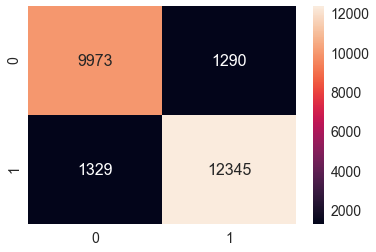

In [132]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [133]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.88      0.89      0.88     11263
   positive       0.91      0.90      0.90     13674

avg / total       0.90      0.89      0.89     24937



***ROC CURVE - TFIDF - LOG REG***

In [134]:
# Predict classes using bOW Log Reg 
pred_prob = model_tfidf_logisticreg_random.predict_proba(X_test)
# Display first 5 predictions
pred_prob[:10]

array([[9.99999772e-01, 2.28346001e-07],
       [9.96556600e-01, 3.44339981e-03],
       [9.99418995e-01, 5.81005120e-04],
       [4.98707141e-01, 5.01292859e-01],
       [9.99739506e-01, 2.60494380e-04],
       [4.82989741e-01, 5.17010259e-01],
       [9.96164137e-01, 3.83586257e-03],
       [9.67665041e-01, 3.23349588e-02],
       [1.00000000e+00, 1.86947372e-11],
       [7.77275880e-04, 9.99222724e-01]])

In [135]:
#fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:, 1])
y_test[0:10]

array(['negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive'],
      dtype=object)

In [136]:
y_test_binary=np.where(y_test=="positive",1,0)

In [137]:
#fpr, tpr, thresholds = roc_curve(y_test_NB,Y_score[:, 1])
fpr, tpr, thresholds = roc_curve(y_test_binary,pred_prob[:, 1])

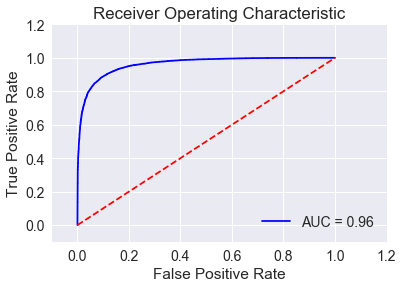

In [138]:
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**AVG - WORD2VEC**

**NEW CODE WITH VECTORIZATION**

In [139]:
print("AVG - WORD2VEC STARTED:")

AVG - WORD2VEC STARTED:


In [140]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [141]:
final.fillna('_NA_')
final = standardize_text(final, "Text")
#train_comments.to_csv("train_clean_data.csv")
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
16089,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,positive,1256774400,It's a great book!,i've always loved chicken soup and rice my la...,ive alway love chicken soup rice late ethel al...
65,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,this is one of the best children's books ever ...,one best children book ever written mini versi...
22817,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,this is a book of poetry about the months of t...,book poetri month year goe month cute littl po...
3836,171238,7310172001,A371KZ5U8RQ5PL,rpatter,0,0,positive,1347580800,Gimborn Liver Bits Treats,we have been using these treats for a very lon...,use treat long time decad find accept almost d...
10900,171272,7310172001,A2B0YKE5HE3I9F,SA Bill,0,0,positive,1319673600,Perfect for Small Dogs,"our two dogs love this product, and we love th...",two dog love product love fact load chemic pre...


In [142]:
tokenizer = RegexpTokenizer(r'\w+')
#clean_train_comments = pd.read_csv("train_clean_data.csv")
final['Text'] = final['Text'].astype('str') 
print(type(final['Text']))
print(final['Text'][0:1])
final["tokens"] = final["Text"].apply(tokenizer.tokenize)
# delete Stop Words
final["tokens"] = final["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
   
final.head()

<class 'pandas.core.series.Series'>
16089    i've always loved chicken soup and rice  my la...
Name: Text, dtype: object


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,tokens
16089,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,positive,1256774400,It's a great book!,i've always loved chicken soup and rice my la...,ive alway love chicken soup rice late ethel al...,"[always, loved, chicken, soup, rice, late, gre..."
65,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,this is one of the best children's books ever ...,one best children book ever written mini versi...,"[one, best, children, books, ever, written, mi..."
22817,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,this is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,"[book, poetry, months, year, goes, month, cute..."
3836,171238,7310172001,A371KZ5U8RQ5PL,rpatter,0,0,positive,1347580800,Gimborn Liver Bits Treats,we have been using these treats for a very lon...,use treat long time decad find accept almost d...,"[using, treats, long, time, decades, find, acc..."
10900,171272,7310172001,A2B0YKE5HE3I9F,SA Bill,0,0,positive,1319673600,Perfect for Small Dogs,"our two dogs love this product, and we love th...",two dog love product love fact load chemic pre...,"[two, dogs, love, product, love, fact, loaded,..."


In [143]:
%%time
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
#    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print( "Training model...")
model = word2vec.Word2Vec(final['tokens'], workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

Training model...
Wall time: 34.6 s


In [144]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [145]:
# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_w2v"
model.save(model_name)

In [146]:
model = Word2Vec.load("300features_w2v")

In [147]:
model.wv

In [148]:
w2v_words = list(model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
#print(model.wv['product'])

number of words that occured minimum 5 times  18379
sample words  ['always', 'loved', 'chicken', 'soup', 'rice', 'late', 'great', 'grandmother', 'ethel', 'made', 'homemade', 'book', 'takes', 'back', 'days', 'mother', 'father', 'sister', 'went', 'house', 'grandfather', 'would', 'cook', 'blind', 'reminds', 'time', 'together', 'family', 'brings', 'happy', 'memories', 'love', 'shared', 'bowls', 'hot', 'one', 'best', 'children', 'books', 'ever', 'written', 'mini', 'version', 'portrayed', 'priced', 'product', 'sent', 'email', 'regarding', 'amazon']


In [149]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    #print("generate_missing: ",generate_missing)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [150]:
%%time
# training_embeddings = get_word2vec_embeddings(word2vec, clean_train_comments, generate_missing=True)
training_embeddings = get_word2vec_embeddings(model, final, generate_missing=True)

Wall time: 25.5 s


In [151]:
print(np.random.rand(10))

[0.38801504 0.04810001 0.21019592 0.46554948 0.75689796 0.25136001
 0.0914838  0.43870091 0.41695176 0.47594857]


In [152]:
print(type(training_embeddings))
#print(training_embeddings[0:2])

<class 'list'>


**TRAINING - AVG-W2VEC**

In [153]:
y = final.Score
X = final.drop('Score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3
                                                    ,shuffle=False,random_state=60)

print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape) 
print("X_train type: ",type(X_train)) 

Test Data Size:  (24937, 11)
Train Data Size:  (58185, 11)
X_train type:  <class 'pandas.core.frame.DataFrame'>


In [154]:
vector = Word2Vec.load("300features_w2v")

def get_average_word2vec(tokens_list, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings( clean_comments):
    embeddings = clean_comments['tokens'].apply(lambda z: get_average_word2vec(z))
    return list(embeddings)
    #return np.array(embeddings)
    #return embeddings

In [155]:
X_train[0:1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,tokens
16089,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,1256774400,It's a great book!,i've always loved chicken soup and rice my la...,ive alway love chicken soup rice late ethel al...,"[always, loved, chicken, soup, rice, late, gre..."


In [156]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):
    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_
    print(type(cv_results))

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())
        # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]
    
    # display the top 'num_results' results
    # =====================================
   # display(pd.DataFrame(cv_results).sort_values(by='rank_test_score').head(num_results))
# plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)       
    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]
    
    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

In [157]:
# Pipeline dictionary
pipelines_avg_w2vec_logisticreg = Pipeline([
    ('avgw2vec',FunctionTransformer(get_word2vec_embeddings, validate=False)),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression()),
])

In [158]:
# List tuneable hyperparameters of our  pipeline
pipelines_avg_w2vec_logisticreg.get_params()

{'memory': None,
 'steps': [('avgw2vec', FunctionTransformer(accept_sparse=False,
             func=<function get_word2vec_embeddings at 0x00000214B9BFCD90>,
             inv_kw_args=None, inverse_func=None, kw_args=None,
             pass_y='deprecated', validate=False)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'avgw2vec': FunctionTransformer(accept_sparse=False,
           func=<function get_word2vec_embeddings at 0x00000214B9BFCD90>,
           inv_kw_args=None, inverse_func=None, kw_args=None,
           pass_y='deprecated', validate=False),
 'normalizer': Normalizer(copy=True, norm='l2'),
 'logisticreg': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=T

In [159]:
pipelines_avg_w2vec_logisticreg.get_params().keys()

dict_keys(['memory', 'steps', 'avgw2vec', 'normalizer', 'logisticreg', 'avgw2vec__accept_sparse', 'avgw2vec__func', 'avgw2vec__inv_kw_args', 'avgw2vec__inverse_func', 'avgw2vec__kw_args', 'avgw2vec__pass_y', 'avgw2vec__validate', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [160]:
hyperparameters_avg_w2vec_logisticreg = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [161]:
# Create empty dictionary called fitted_models
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
print("X_train SHAPE: ",X_train.shape)
print("y_train SHAPE: ",y_train.shape)

X_train SHAPE:  (58185, 11)
y_train SHAPE:  (58185,)


In [162]:
print("AVGW2VEC - LOG REG - GRID SEARCH STARTED:")

model_avg_w2vec_logisticreg = GridSearchCV(pipelines_avg_w2vec_logisticreg, hyperparameters_avg_w2vec_logisticreg, cv=tscv, n_jobs=1,verbose=1)

AVGW2VEC - LOG REG - GRID SEARCH STARTED:


In [163]:
model_avg_w2vec_logisticreg.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 154.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('avgw2vec', FunctionTransformer(accept_sparse=False,
          func=<function get_word2vec_embeddings at 0x00000214B9BFCD90>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('normalizer', Normalizer(copy=True, norm='l2')), ('logi...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [164]:
#print("Best Estimator for BOW MultinomialNB",model_bow_MultinomialNB.best_estimator_)
print("Best Score for AVG W2VEC model_bow_logisticreg",model_avg_w2vec_logisticreg.best_score_)
print("Best Parms for AVG W2VEC model_bow_logisticreg",model_avg_w2vec_logisticreg.best_params_)

Best Score for AVG W2VEC model_bow_logisticreg 0.8702506989321234
Best Parms for AVG W2VEC model_bow_logisticreg {'logisticreg__C': 1000, 'logisticreg__penalty': 'l1'}


In [165]:
# coefficients are in the best_estimator_ attribute
coef_avg_w2vec_logisticreg = model_avg_w2vec_logisticreg.best_estimator_.get_params()['logisticreg'].coef_
print(coef_avg_w2vec_logisticreg)
print(model_avg_w2vec_logisticreg.best_estimator_.get_params()['logisticreg'].coef_[0])

[[-2.66019011e+01 -1.08851095e+01  3.90692804e+01 -3.64608091e+01
   2.47564382e+01  2.23108216e+01 -1.78908577e+01 -7.80663826e+01
  -6.01800928e+00 -1.53777379e+01  4.50437881e+00 -6.08358297e+01
   1.68726568e+01  6.39133409e+01 -7.38219852e+01  1.68227885e+01
   3.71101683e+01 -3.54446619e+01 -1.55485630e+01 -3.00079253e+01
  -1.81258392e+01  8.72259896e+01  1.93227816e+01  3.90665654e+01
   1.13339339e+01 -5.79387779e+01  6.95873816e+01 -1.48090732e+01
  -1.79304562e+01 -3.72952496e+01  1.40908357e+01 -5.58452325e+01
   9.49966409e+00  1.14041776e+01  6.97352934e+00  9.73527277e+00
   2.53219195e+01 -1.02771571e+01  2.24397985e+01 -3.82518067e+01
   3.17456077e+01  4.45040182e+01 -1.14201742e+01 -3.60846447e+00
   7.16785562e+01  1.74049358e+01  1.16568601e+01  3.86320307e+01
   3.31315661e+01 -3.99534766e+01  2.37506578e+01 -8.40649884e+00
   3.37146366e+01 -7.67003179e+01 -2.06404709e+01  1.48301174e+01
   4.82065346e+00  1.71990694e+01  3.03699692e+01  2.30725719e+01
   2.59964

<class 'sklearn.utils.deprecation.DeprecationDict'>
best parameters: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l1'}
best score:      0.87025 (+/-0.00131)
{'avgw2vec': FunctionTransformer(accept_sparse=False,
          func=<function get_word2vec_embeddings at 0x00000214B9BFCD90>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False),
 'avgw2vec__accept_sparse': False,
 'avgw2vec__func': <function get_word2vec_embeddings at 0x00000214B9BFCD90>,
 'avgw2vec__inv_kw_args': None,
 'avgw2vec__inverse_func': None,
 'avgw2vec__kw_args': None,
 'avgw2vec__pass_y': 'deprecated',
 'avgw2vec__validate': False,
 'logisticreg': LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
 'logisticreg__C': 1000,
 'logisticreg__class_wei

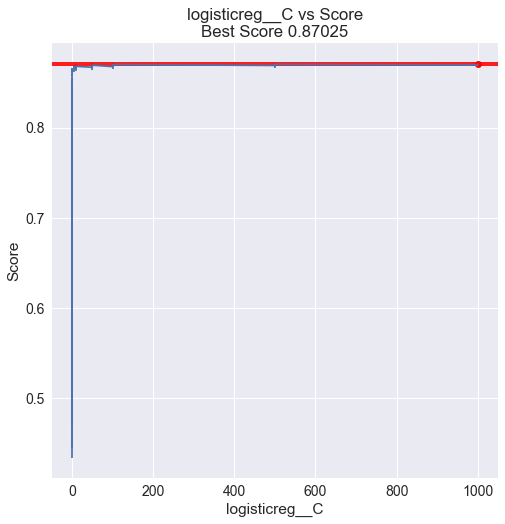

In [166]:
GridSearch_table_plot(model_avg_w2vec_logisticreg, "logisticreg__C"
                      , negative=False)

[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
[0.12974930106787663, 0.1297951326825244, 0.13000137494843944, 0.13068884916815615, 0.13197213437829414, 0.13346166185434716, 0.13598240065997524, 0.13630322196250977, 0.14191759475686327, 0.14817361015628583, 0.17720793803565704, 0.27496677207938036, 0.4808423850772263, 0.5186534671616481, 0.5506897658004491]


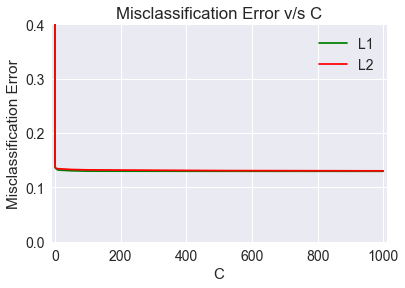

In [167]:
plot_error_vs_c(model_avg_w2vec_logisticreg)

In [168]:
model_avg_w2vec_logisticreg.grid_scores_

[mean: 0.87025, std: 0.00131, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l1'},
 mean: 0.86949, std: 0.00214, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l2'},
 mean: 0.87020, std: 0.00138, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l1'},
 mean: 0.86899, std: 0.00248, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l2'},
 mean: 0.87000, std: 0.00221, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l1'},
 mean: 0.86771, std: 0.00283, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l2'},
 mean: 0.86931, std: 0.00196, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l1'},
 mean: 0.86700, std: 0.00278, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l2'},
 mean: 0.86803, std: 0.00234, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l1'},
 mean: 0.86560, std: 0.00252, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l2'},
 mean: 0.86654, std: 0.00248, params: {'logisticreg__C': 5, 'logisticreg

In [169]:
# Predict classes using  
pred = model_avg_w2vec_logisticreg.predict(X_test)
# Display first 5 predictions
pred[:10]

array(['negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive'],
      dtype=object)

In [170]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_avg_w2vec_grid = accuracy_score(y_test, pred, normalize=True) * 100
print('Accuracy of the {} model on unseen data is {} %'.format("AVG W2VEC: ", np.round(test_accuracy_avg_w2vec_grid,2)))

Accuracy of the AVG W2VEC:  model on unseen data is 87.27 %


In [171]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9786  1477]
 [ 1697 11977]]


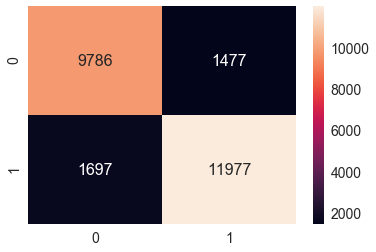

In [172]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [173]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.85      0.87      0.86     11263
   positive       0.89      0.88      0.88     13674

avg / total       0.87      0.87      0.87     24937



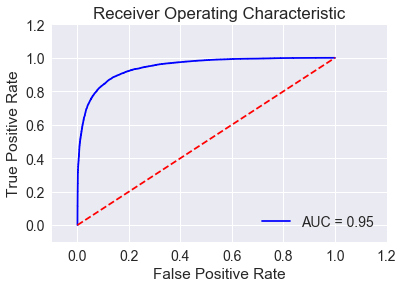

In [174]:
# Predict classes using AVG W2VEC GRID SEARCH Log Reg 
pred_prob = model_avg_w2vec_logisticreg.predict_proba(X_test)
# Display first 5 predictions
pred_prob[:10]

#fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:, 1])
y_test[0:10]


y_test_binary=np.where(y_test=="positive",1,0)

#fpr, tpr, thresholds = roc_curve(y_test_NB,Y_score[:, 1])
fpr, tpr, thresholds = roc_curve(y_test_binary,pred_prob[:, 1])

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

***Randomized Search  ***

In [175]:
y = final.Score
X = final.drop('Score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3
                                                    ,shuffle=False,random_state=60)

print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape) 
print("X_train type: ",type(X_train)) 

Test Data Size:  (24937, 11)
Train Data Size:  (58185, 11)
X_train type:  <class 'pandas.core.frame.DataFrame'>


In [176]:
vector = Word2Vec.load("300features_w2v")

def get_average_word2vec(tokens_list, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings( clean_comments):
    embeddings = clean_comments['tokens'].apply(lambda z: get_average_word2vec(z))
    return list(embeddings)
    #return np.array(embeddings)
    #return embeddings

In [177]:
# Pipeline dictionary
pipelines_avg_w2vec_logisticreg_random = Pipeline([
    ('avgw2vec',FunctionTransformer(get_word2vec_embeddings, validate=False)),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression()),
])

In [178]:
# List tuneable hyperparameters of our  pipeline
pipelines_avg_w2vec_logisticreg_random.get_params()

{'memory': None,
 'steps': [('avgw2vec', FunctionTransformer(accept_sparse=False,
             func=<function get_word2vec_embeddings at 0x00000214B7AD2D08>,
             inv_kw_args=None, inverse_func=None, kw_args=None,
             pass_y='deprecated', validate=False)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'avgw2vec': FunctionTransformer(accept_sparse=False,
           func=<function get_word2vec_embeddings at 0x00000214B7AD2D08>,
           inv_kw_args=None, inverse_func=None, kw_args=None,
           pass_y='deprecated', validate=False),
 'normalizer': Normalizer(copy=True, norm='l2'),
 'logisticreg': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=T

In [179]:
pipelines_avg_w2vec_logisticreg_random.get_params().keys()

dict_keys(['memory', 'steps', 'avgw2vec', 'normalizer', 'logisticreg', 'avgw2vec__accept_sparse', 'avgw2vec__func', 'avgw2vec__inv_kw_args', 'avgw2vec__inverse_func', 'avgw2vec__kw_args', 'avgw2vec__pass_y', 'avgw2vec__validate', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [180]:
hyperparameters_avg_w2vec_logisticreg_random = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [181]:
# Create empty dictionary called fitted_models
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
print("X_train SHAPE: ",X_train.shape)
print("y_train SHAPE: ",y_train.shape)

X_train SHAPE:  (58185, 11)
y_train SHAPE:  (58185,)


In [182]:
model_avg_w2vec_logisticreg_random = RandomizedSearchCV(pipelines_avg_w2vec_logisticreg_random,
                                                  hyperparameters_avg_w2vec_logisticreg_random, cv=tscv, n_jobs=1,verbose=1)

In [183]:
model_avg_w2vec_logisticreg_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 74.3min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('avgw2vec', FunctionTransformer(accept_sparse=False,
          func=<function get_word2vec_embeddings at 0x00000214B7AD2D08>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('normalizer', Normalizer(copy=True, norm='l2')), ('logi...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [184]:
#print("Best Estimator for BOW MultinomialNB",model_bow_MultinomialNB.best_estimator_)
print("Best Score for AVG W2VEC model_bow_logisticreg",model_avg_w2vec_logisticreg_random.best_score_)
print("Best Parms for AVG W2VEC model_bow_logisticreg",model_avg_w2vec_logisticreg_random.best_params_)

Best Score for AVG W2VEC model_bow_logisticreg 0.8702506989321234
Best Parms for AVG W2VEC model_bow_logisticreg {'logisticreg__penalty': 'l1', 'logisticreg__C': 500}


In [185]:
# coefficients are in the best_estimator_ attribute
coef_avg_w2vec_logisticreg_random = model_avg_w2vec_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_
print(coef_avg_w2vec_logisticreg_random)
print(model_avg_w2vec_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_[0])

[[ -21.09589513   -6.74350818   38.23435838  -33.49446639   21.33342793
    16.30063886  -18.65350607  -68.6664048    -5.34601398  -12.89346445
     0.7632042   -56.66169549   16.31968216   54.77212557  -61.05793574
    17.65604469   31.39710227  -29.64806073  -13.83584033  -27.37084965
   -14.81062764   73.34436657   15.4715644    28.90052966    7.51509159
   -52.63852058   60.15430909  -13.87271583  -15.54719647  -28.65759257
     7.51028966  -52.33176745    9.82726344    4.34107896    6.02846117
    13.39863007   18.77785591   -7.11628354   22.06586589  -35.81191452
    26.65159377   44.0942941    -7.38160095   -9.02223527   59.48760878
    19.83312866    9.89394144   38.39544064   27.26241321  -35.67878096
    24.2786769    -6.69779539   30.35383704  -69.66492828  -14.97359055
    12.38245663    2.57229546   13.29299303   25.68861907   25.17375415
    25.65393407 -106.51292555   50.50873073  -26.74709312   56.75499467
    -5.58576046   -5.64288676   23.13891365   75.37116452  -65.1

In [186]:
# Predict classes using  
pred = model_avg_w2vec_logisticreg_random.predict(X_test)
pred[0:5]

array(['negative', 'negative', 'negative', 'positive', 'negative'],
      dtype=object)

In [187]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_avg_w2vec_random = accuracy_score(y_test, pred, normalize=True) * 100
print('Accuracy of the {} model on unseen data is {} %'.format("avg_w2vec Log Reg", np.round(test_accuracy_avg_w2vec_random,2)))

Accuracy of the avg_w2vec Log Reg model on unseen data is 87.24 %


In [188]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9787  1476]
 [ 1705 11969]]


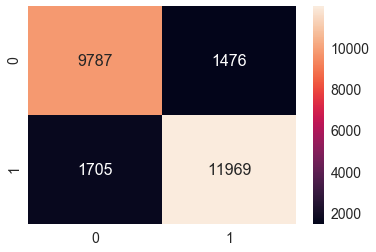

In [189]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [190]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.85      0.87      0.86     11263
   positive       0.89      0.88      0.88     13674

avg / total       0.87      0.87      0.87     24937



***ROC CURVE - AVG W2VEC - LOG REG***

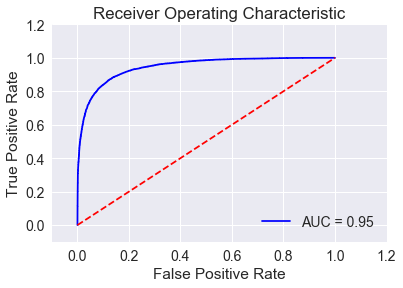

In [191]:
# Predict classes using bOW Log Reg 
pred_prob = model_avg_w2vec_logisticreg_random.predict_proba(X_test)
# Display first 5 predictions
pred_prob[:10]

#fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:, 1])
y_test[0:10]


y_test_binary=np.where(y_test=="positive",1,0)

#fpr, tpr, thresholds = roc_curve(y_test_NB,Y_score[:, 1])
fpr, tpr, thresholds = roc_curve(y_test_binary,pred_prob[:, 1])

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**TFIDF-W2V**

In [192]:
print("TFIDF-W2VEC  SAMPLE WORKING-STEP BY STEP STARTED:")

TFIDF-W2VEC  SAMPLE WORKING-STEP BY STEP STARTED:


In [193]:
final['tokens_to_text']=[" ".join(review) for review in final['tokens'].values]
y = final.Score
X = final.drop('Score', axis=1)
#https://datascience.stackexchange.com/questions/24376/use-of-tfidfvectorizer-on-dataframe/24399#24399
#X['tokens_to_text']=[" ".join(review) for review in X['tokens'].values]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3
                                                    ,shuffle=False,random_state=60)
print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape) 
print("X_train type: ",type(X_train)) 
X_train.head()

Test Data Size:  (24937, 12)
Train Data Size:  (58185, 12)
X_train type:  <class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,tokens,tokens_to_text
16089,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,1256774400,It's a great book!,i've always loved chicken soup and rice my la...,ive alway love chicken soup rice late ethel al...,"[always, loved, chicken, soup, rice, late, gre...",always loved chicken soup rice late great gran...
65,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,1129507200,awesome book poor size,this is one of the best children's books ever ...,one best children book ever written mini versi...,"[one, best, children, books, ever, written, mi...",one best children books ever written mini vers...
22817,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1018396800,A great way to learn the months,this is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,"[book, poetry, months, year, goes, month, cute...",book poetry months year goes month cute little...
3836,171238,7310172001,A371KZ5U8RQ5PL,rpatter,0,0,1347580800,Gimborn Liver Bits Treats,we have been using these treats for a very lon...,use treat long time decad find accept almost d...,"[using, treats, long, time, decades, find, acc...",using treats long time decades find accepted a...
10900,171272,7310172001,A2B0YKE5HE3I9F,SA Bill,0,0,1319673600,Perfect for Small Dogs,"our two dogs love this product, and we love th...",two dog love product love fact load chemic pre...,"[two, dogs, love, product, love, fact, loaded,...",two dogs love product love fact loaded chemica...


In [194]:
print(type(X_train['tokens']))
print(X_train['tokens'].index)
print(X_train['tokens'][0:5])
print(X_train['Text'][0:5])

<class 'pandas.core.series.Series'>
Int64Index([16089,    65, 22817,  3836, 10900, 33883, 40947, 43407,  3823,
            27854,
            ...
            11819,  8445, 24209,  2332,  8627, 20928, 43750,  3407, 17930,
            25503],
           dtype='int64', length=58185)
16089    [always, loved, chicken, soup, rice, late, gre...
65       [one, best, children, books, ever, written, mi...
22817    [book, poetry, months, year, goes, month, cute...
3836     [using, treats, long, time, decades, find, acc...
10900    [two, dogs, love, product, love, fact, loaded,...
Name: tokens, dtype: object
16089    i've always loved chicken soup and rice  my la...
65       this is one of the best children's books ever ...
22817    this is a book of poetry about the months of t...
3836     we have been using these treats for a very lon...
10900    our two dogs love this product, and we love th...
Name: Text, dtype: object


In [195]:
vector = Word2Vec.load("300features_w2v")

In [196]:
#https://www.reddit.com/r/learnpython/comments/351xi5/how_to_produce_the_sum_of_two_2d_lists_by_element/    How to produce the sum of two 2D lists by element?
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
def get_tf_idf_word2vect_embeddings( clean_comments):
    #############TFIDF #########################################
    tf_idf_vect = TfidfVectorizer()
    final_tf_idf = tf_idf_vect.fit_transform(clean_comments['Text'])
    tfidf_feat = tf_idf_vect.get_feature_names()
    #print("final_tf_idf SHAPE: ",final_tf_idf.shape)
    
    #print("CALCULATING NUMERATOR: ")
    #vectorized=[vector.wv[word] * final_tf_idf[index1, tfidf_feat.index(word)]
    #vectorized=[(word,vector.wv[word])
    #vectorized=[(index1,final_tf_idf[index1, tfidf_feat.index(word)])
    #vectorized=[(index1,tfidf_feat.index(word)) # NOT WORKING
    #vectorized=[(index1,word)
    #vectorized=[(index1,final_tf_idf[index1])
    #vectorized=[(index1,vector.wv[word])
    #vectorized=[(index1)
    #for index1,sent in enumerate(clean_comments['tokens'])
    #for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]               

    # WORKING CODE FOR vectorized_sum #############################33
    #vectorized_sum=[[[np.sum(vector.wv[word]*final_tf_idf[index1, tfidf_feat.index(word)],axis=0)]
    vectorized=[[[vector.wv[word]*final_tf_idf[index1, tfidf_feat.index(word)]]
        for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]
        for index1,sent in enumerate(clean_comments['tokens'])]
    
    # print ("vectorized:" , vectorized) # UNCOMMENT FOR TESTING
    vectorized_sum=[[sum(j) for j in zip(*i)] for i in vectorized]
    
    
    #vectorized_sum=[[sum(vector.wv[word]*final_tf_idf[index1, tfidf_feat.index(word)] 
     #                    if not word and word  not in tf_idf_vect.vocabulary_.keys())
      #  for word in sent #if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]
      #  for index1,sent in enumerate(clean_comments['tokens'])]

    #print("VECTORIZED: ")
    #print("VECTORIZED SHAPE: ",len(vectorized_sum))
    #print(vectorized_sum)
    
    #https://stackoverflow.com/questions/21046417/python-conversion-of-list-of-arrays-to-2d-array
    zero_array=[np.array([0]*300,dtype=float)] #ENTER NOS OF DIM IN WORD2VEC
    vectorized_sum_zero=[i if len(i)!=0 else zero_array for i in vectorized_sum]
    print(len(vectorized_sum_zero))
    print(type(vectorized_sum_zero))
    vectorized_sum_zero_array=np.array(vectorized_sum_zero)
    print("vectorized_sum_zero_array SHAPE : ",vectorized_sum_zero_array.shape)
    print(type(vectorized_sum_zero_array))
    
    #print("CALCULATING DENOMINATOR: ")
    #tfidf_length=[final_tf_idf[index1, tfidf_feat.index(word)]
    #for index1,sent in enumerate(clean_comments['tokens'])
    #for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]  
    
    tfidf_length=[[final_tf_idf[index1, tfidf_feat.index(word)] 
        for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]
        for index1,sent in enumerate(clean_comments['tokens'])]
    
    
    
    print("TFIDF_LENGTH LENGHT: ",len(tfidf_length))
    #print(tfidf_length)
    
    tfidf_length_sum = [sum(row) for row in tfidf_length ] 
    print("tfidf_length_sum: ")
    print("tfidf_length_sum SHAPE: ",len(tfidf_length_sum))
    #print(tfidf_length_sum)
    
    print("tfidf_length_sum ELEMENT 0: ",tfidf_length_sum[0]) # UNCOMMENT FOR TESTING
    print("\ntfidf_length_sum ELEMENT 1: ",tfidf_length_sum[1]) # UNCOMMENT FOR TESTING
    
    
    #averaged=[[np.divide(word,tfidf_length_sum[index1]) 
    #for word in sent]
    #for index1,sent in enumerate(vectorized_sum)]

    #averaged=[[word/[tfidf_length_sum[index1]] 

    #ENTER NOS OF DIM IN WORD2VEC
    averaged=[[np.divide(word,tfidf_length_sum[index1]) if tfidf_length_sum[index1] !=0 else np.zeros(300) 
        for word in sent]
        for index1,sent in enumerate(vectorized_sum_zero)]
    
    #print("averaged LENGTH: ",len(averaged))
    #print("averaged ELEMENT 0 : ",averaged[0]) # UNCOMMENT FOR TESTING
    #print("averaged ELEMENT 1 : ",averaged[1]) # UNCOMMENT FOR TESTING
    
    
    #print("ZIP ")
    #print (*zip(vectorized_sum,tfidf_length_sum))

    #tfidf_word2vec_sum = np.sum(vectorized, axis=0)
    #sprint(tfidf_word2vec_sum)
    
    #averaged = np.divide(vectorized_sum, tfidf_length_sum)
    #averaged = np.divide(vectorized, tfidf_length_sum)
    
    #print("averaged: ",averaged) # UNCOMMENT FOR TESTING
    
    #print("get_tf_idf_word2vect_embeddings COMPLETED")
    #print("SHAPE OF averaged: ",vectorized.shape)
    ##print("LENGTH OF averaged: ",len(averaged))
    ##print("TYPE OF averaged: ",type(averaged))
    #averaged=averaged.reshape(-1,1)
    #print("TYPE OF averaged: ",type(averaged))
    #averaged_array=np.asarray(averaged)
    #print("TYPE OF averaged_array: ",type(averaged_array))
    #averaged_array_2d=averaged_array.reshape(-1,1)
    #print("TYPE OF averaged_array_2d: ",type(averaged_array_2d))
    #print("SHAPE OF averaged_array_2d: ",averaged_array_2d.shape)
    #print("averaged_array: ",averaged_array)
    averaged_array=np.array(averaged)
    ##print("averaged_array: ",type(averaged_array))
    print("averaged_array SHAPE: ",averaged_array.shape)
    
    #NEWLY ADDED
    averaged_array_length=len(averaged_array)
    print("averaged_array_length LENGTH: ",averaged_array_length)
    averaged_array_reshape=averaged_array.reshape(averaged_array_length,-1)
    print("averaged_array_reshape LENGTH: ",len(averaged_array_reshape))
    print("averaged_array_reshape SHAPE: ",averaged_array_reshape.shape)
    return averaged_array_reshape
    #return list(vectorized)

In [197]:
tf_idf_vect = TfidfVectorizer()
#final_tf_idf = tf_idf_vect.fit_transform(X_train['tokens_to_text'])
final_tf_idf = tf_idf_vect.fit_transform(X_train['Text'])
print(X_train['Text'].shape)
print(final_tf_idf.shape)
print(type(final_tf_idf))

(58185,)
(58185, 46420)
<class 'scipy.sparse.csr.csr_matrix'>


In [198]:
# TF-IDF (scikit-learn's default implementation)
#type(final_tf_idf)
print(final_tf_idf.toarray().shape)
print(type(final_tf_idf.toarray()))
pd.DataFrame(final_tf_idf.toarray(), columns=tf_idf_vect.get_feature_names()).head()

(58185, 46420)
<class 'numpy.ndarray'>


,00,000,000001,00001,0001,0004,000mg,000usd,001,002,...,zvijezda,zweiback,zwieback,zyliss,zylitol,zylitor,zymox,zzzzz,zzzzzzz,zzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
#normal1=preprocessing.Normalizer()
#https://stackoverflow.com/questions/4674473/valueerror-setting-an-array-element-with-a-sequence
#X_train_dtm_normal1 = normal1.fit_transform(averaged_array_reshape)
#print(type(X_train_dtm_normal1))
#print(X_train_dtm_normal1.shape)

In [200]:
# Pipeline dictionary
pipelines_tfidfw2v_logisticreg = Pipeline([
    ('tfidfw2v',FunctionTransformer(get_tf_idf_word2vect_embeddings, validate=False)),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression()),
])

In [201]:
# List tuneable hyperparameters of our  pipeline
pipelines_tfidfw2v_logisticreg.get_params()

{'memory': None,
 'steps': [('tfidfw2v', FunctionTransformer(accept_sparse=False,
             func=<function get_tf_idf_word2vect_embeddings at 0x00000214E9B8F048>,
             inv_kw_args=None, inverse_func=None, kw_args=None,
             pass_y='deprecated', validate=False)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'tfidfw2v': FunctionTransformer(accept_sparse=False,
           func=<function get_tf_idf_word2vect_embeddings at 0x00000214E9B8F048>,
           inv_kw_args=None, inverse_func=None, kw_args=None,
           pass_y='deprecated', validate=False),
 'normalizer': Normalizer(copy=True, norm='l2'),
 'logisticreg': LogisticRegression(C=1.0, class_weight=None, dual=False,

In [202]:
pipelines_tfidfw2v_logisticreg.get_params().keys()

dict_keys(['memory', 'steps', 'tfidfw2v', 'normalizer', 'logisticreg', 'tfidfw2v__accept_sparse', 'tfidfw2v__func', 'tfidfw2v__inv_kw_args', 'tfidfw2v__inverse_func', 'tfidfw2v__kw_args', 'tfidfw2v__pass_y', 'tfidfw2v__validate', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [203]:
hyperparameters_tfidfw2v_logisticreg = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [204]:
# Create empty dictionary called fitted_models
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
print("X_train SHAPE: ",X_train.shape)
print("y_train SHAPE: ",y_train.shape)

X_train SHAPE:  (58185, 12)
y_train SHAPE:  (58185,)


In [205]:
print("AVGW2VEC - LOG REG - GRID SEARCH STARTED:")

model_tfidfw2v_logisticreg = GridSearchCV(pipelines_tfidfw2v_logisticreg, hyperparameters_tfidfw2v_logisticreg, cv=tscv, n_jobs=1,verbose=1)

AVGW2VEC - LOG REG - GRID SEARCH STARTED:


In [206]:
model_tfidfw2v_logisticreg.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  4.154672083921081

tfidf_length_sum ELEMENT 1:  2.815769728294452
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'nump

TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  4.154672083921081

tfidf_length_sum ELEMENT 1:  2.815769728294452
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum EL

29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  6.588404982587214

tfidf_length_sum ELEMENT 1:  5.203942549458936
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfi

TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  6.588404982587214

tfidf_length_sum ELEMENT 1:  5.203942549458936
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELE

averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELEMENT 1:  3.6085857945440174
averaged_array SHAPE:  (43639, 1, 300)
averaged_array_length LENGTH:  43639
averaged_array_reshape LENGTH:  43639
averaged_array_reshape SHAPE:  (43639, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  5.452169595359681

tfidf_length_sum ELEMENT 1:  6.587515298711804
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  

14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  5.452169595359681

tfidf_length_sum ELEMENT 1:  6.587515298711804
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELEMENT 1:  3.6085857945440174
averaged_array SHAPE:  (43639, 1, 300)
averaged_array_length LENGTH:  43639
averaged_array_reshape LENGTH:  43639
averaged_array_reshape SHAPE:  (43639, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tf

TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELEMENT 1:  3.6085857945440174
averaged_array SHAPE:  (43639, 1, 300)
averaged_array_length LENGTH:  43639
averaged_array_reshape LENGTH:  43639
averaged_array_reshape SHAPE:  (43639, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  4.154672083921081

tfidf_length_sum E

14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  4.154672083921081

tfidf_length_sum ELEMENT 1:  2.815769728294452
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tf

TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  6.588404982587214

tfidf_length_sum EL

averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  6.588404982587214

tfidf_length_sum ELEMENT 1:  5.203942549458936
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (

29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELEMENT 1:  3.6085857945440174
averaged_array SHAPE:  (43639, 1, 300)
averaged_array_length LENGTH:  43639
averaged_array_reshape LENGTH:  43639
averaged_array_reshape SHAPE:  (43639, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tf

TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELEMENT 1:  3.6085857945440174
averaged_array SHAPE:  (43639, 1, 300)
averaged_array_length LENGTH:  43639
averaged_array_reshape LENGTH:  43639
averaged_array_reshape SHAPE:  (43639, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  5.452169595359681

tfidf_length_sum ELEMENT 1:  6.587515298711804
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum EL

43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELEMENT 1:  3.6085857945440174
averaged_array SHAPE:  (43639, 1, 300)
averaged_array_length LENGTH:  43639
averaged_array_reshape LENGTH:  43639
averaged_array_reshape SHAPE:  (43639, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
t

TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  4.154672083921081

tfidf_length_sum ELEMENT 1:  2.815769728294452
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum EL

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 9160.2min finished


58185
<class 'list'>
vectorized_sum_zero_array SHAPE :  (58185, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  58185
tfidf_length_sum: 
tfidf_length_sum SHAPE:  58185
tfidf_length_sum ELEMENT 0:  7.729005285416266

tfidf_length_sum ELEMENT 1:  3.596628385831183
averaged_array SHAPE:  (58185, 1, 300)
averaged_array_length LENGTH:  58185
averaged_array_reshape LENGTH:  58185
averaged_array_reshape SHAPE:  (58185, 300)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfw2v', FunctionTransformer(accept_sparse=False,
          func=<function get_tf_idf_word2vect_embeddings at 0x00000214E9B8F048>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('normalizer', Normalizer(copy=True, norm='l2'))...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [207]:
#print("Best Estimator for BOW MultinomialNB",model_bow_MultinomialNB.best_estimator_)
print("Best Score for AVG W2VEC model_bow_logisticreg",model_tfidfw2v_logisticreg.best_score_)
print("Best Parms for AVG W2VEC model_bow_logisticreg",model_tfidfw2v_logisticreg.best_params_)

Best Score for AVG W2VEC model_bow_logisticreg 0.8485952610110454
Best Parms for AVG W2VEC model_bow_logisticreg {'logisticreg__C': 500, 'logisticreg__penalty': 'l1'}


In [208]:
# coefficients are in the best_estimator_ attribute
coef_tfidfw2v_logisticreg = model_tfidfw2v_logisticreg.best_estimator_.get_params()['logisticreg'].coef_
print(coef_tfidfw2v_logisticreg)
print(model_tfidfw2v_logisticreg.best_estimator_.get_params()['logisticreg'].coef_[0])

[[-1.42545139e+01  5.24764770e+00  2.38570186e+01 -3.18139017e+01
   1.08254269e+01  3.60615716e+00 -1.72897911e+01 -4.80338573e+01
   6.17423702e-01 -2.06483276e+01 -9.00092664e+00 -3.98409280e+01
  -4.76099001e-02  6.23319126e+01 -6.63191878e+01  4.04437799e+00
   2.85364465e+01 -4.37168636e+01 -3.17763557e+01 -1.61535167e+01
  -1.89193372e+01  6.91656056e+01  5.27024889e+00  3.15596992e+01
   1.83026782e+01 -5.78012293e+01  6.47834473e+01  4.89415227e-01
  -2.35303687e+01 -2.49168350e+01  1.17015602e+01 -4.68723526e+01
   1.04815985e+01  1.33247536e+01  7.06197203e+00  2.37572212e+01
   3.39256501e+01  5.02741223e-01  2.00988853e+01 -5.12505791e+01
  -1.28362764e+00  7.65772545e+01  9.00828044e+00  1.48525792e+01
   4.19942792e+01 -3.82655119e+00  1.46536046e+01  4.70967118e+01
   4.98670797e+01 -3.14162198e+01  2.23987461e+01 -1.15764097e+01
   2.18988976e+00 -5.40593167e+01 -4.57351639e+00  1.02567558e+01
   8.20092897e-02  1.69541478e+01  1.86159483e+01  2.88163039e+01
   2.83569

<class 'sklearn.utils.deprecation.DeprecationDict'>
best parameters: {'logisticreg__C': 500, 'logisticreg__penalty': 'l1'}
best score:      0.84860 (+/-0.00043)
{'logisticreg': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
 'logisticreg__C': 500,
 'logisticreg__class_weight': None,
 'logisticreg__dual': False,
 'logisticreg__fit_intercept': True,
 'logisticreg__intercept_scaling': 1,
 'logisticreg__max_iter': 100,
 'logisticreg__multi_class': 'ovr',
 'logisticreg__n_jobs': 1,
 'logisticreg__penalty': 'l1',
 'logisticreg__random_state': None,
 'logisticreg__solver': 'liblinear',
 'logisticreg__tol': 0.0001,
 'logisticreg__verbose': 0,
 'logisticreg__warm_start': False,
 'memory': None,
 'normalizer': Normalizer(copy=True, norm='l2'),
 'normalizer__copy': True,
 'normaliz

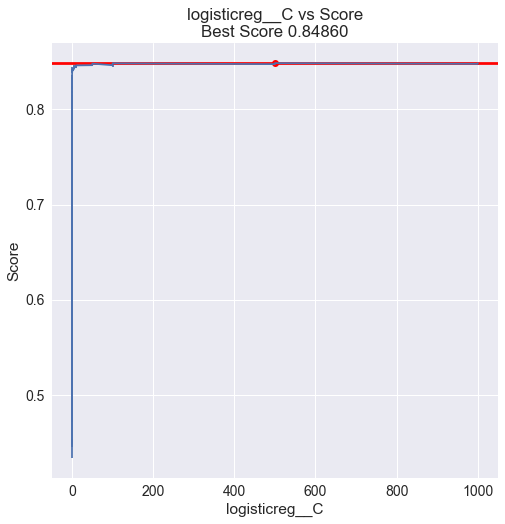

In [209]:
GridSearch_table_plot(model_tfidfw2v_logisticreg, "logisticreg__C"
                      , negative=False)

[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
[0.15151931802557406, 0.15140473898895457, 0.15156514964022183, 0.15190888675008019, 0.15381089875796328, 0.15497960493148177, 0.1574545121224621, 0.1599294193134424, 0.1660937714835694, 0.17351849305651035, 0.20940464732572528, 0.2981575690911591, 0.4808423850772263, 0.5186534671616481, 0.5506897658004491]


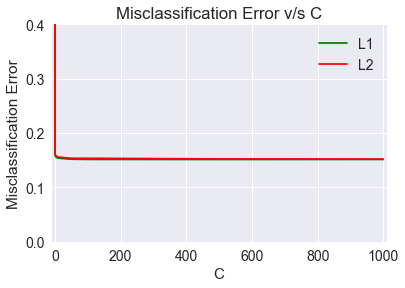

In [210]:
plot_error_vs_c(model_tfidfw2v_logisticreg)

In [211]:
model_tfidfw2v_logisticreg.grid_scores_

[mean: 0.84848, std: 0.00073, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l1'},
 mean: 0.84788, std: 0.00110, params: {'logisticreg__C': 1000, 'logisticreg__penalty': 'l2'},
 mean: 0.84860, std: 0.00043, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l1'},
 mean: 0.84754, std: 0.00084, params: {'logisticreg__C': 500, 'logisticreg__penalty': 'l2'},
 mean: 0.84843, std: 0.00051, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l1'},
 mean: 0.84637, std: 0.00138, params: {'logisticreg__C': 100, 'logisticreg__penalty': 'l2'},
 mean: 0.84809, std: 0.00069, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l1'},
 mean: 0.84644, std: 0.00133, params: {'logisticreg__C': 50, 'logisticreg__penalty': 'l2'},
 mean: 0.84619, std: 0.00134, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l1'},
 mean: 0.84424, std: 0.00096, params: {'logisticreg__C': 10, 'logisticreg__penalty': 'l2'},
 mean: 0.84502, std: 0.00121, params: {'logisticreg__C': 5, 'logisticreg

In [212]:
# Predict classes using  
pred = model_tfidfw2v_logisticreg.predict(X_test)
# Display first 5 predictions
pred[:10]

24937
<class 'list'>
vectorized_sum_zero_array SHAPE :  (24937, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  24937
tfidf_length_sum: 
tfidf_length_sum SHAPE:  24937
tfidf_length_sum ELEMENT 0:  8.182331509388597

tfidf_length_sum ELEMENT 1:  7.272509661994287
averaged_array SHAPE:  (24937, 1, 300)
averaged_array_length LENGTH:  24937
averaged_array_reshape LENGTH:  24937
averaged_array_reshape SHAPE:  (24937, 300)


array(['negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive'],
      dtype=object)

In [213]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_tfidfw2v_grid = accuracy_score(y_test, pred, normalize=True) * 100 
print('Accuracy of the {} model on unseen data is {} %'.format("BOW: ", np.round(test_accuracy_tfidfw2v_grid,2)))

Accuracy of the BOW:  model on unseen data is 85.19 %


In [214]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9482  1781]
 [ 1913 11761]]


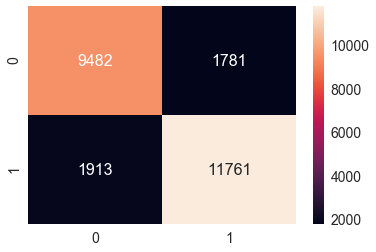

In [215]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [216]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.83      0.84      0.84     11263
   positive       0.87      0.86      0.86     13674

avg / total       0.85      0.85      0.85     24937



24937
<class 'list'>
vectorized_sum_zero_array SHAPE :  (24937, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  24937
tfidf_length_sum: 
tfidf_length_sum SHAPE:  24937
tfidf_length_sum ELEMENT 0:  8.182331509388597

tfidf_length_sum ELEMENT 1:  7.272509661994287
averaged_array SHAPE:  (24937, 1, 300)
averaged_array_length LENGTH:  24937
averaged_array_reshape LENGTH:  24937
averaged_array_reshape SHAPE:  (24937, 300)


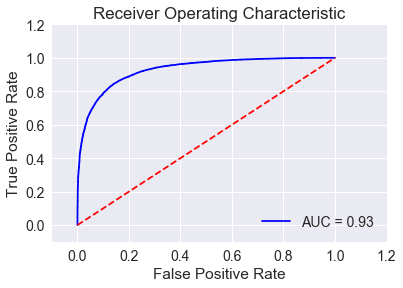

In [217]:
# Predict classes using AVG W2VEC GRID SEARCH Log Reg 
pred_prob = model_tfidfw2v_logisticreg.predict_proba(X_test)
# Display first 5 predictions
pred_prob[:10]

#fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:, 1])
y_test[0:10]


y_test_binary=np.where(y_test=="positive",1,0)

#fpr, tpr, thresholds = roc_curve(y_test_NB,Y_score[:, 1])
fpr, tpr, thresholds = roc_curve(y_test_binary,pred_prob[:, 1])

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

***Randomized Search  ***

In [218]:
y = final.Score
X = final.drop('Score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3
                                                    ,shuffle=False,random_state=60)

print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape) 
print("X_train type: ",type(X_train)) 

Test Data Size:  (24937, 12)
Train Data Size:  (58185, 12)
X_train type:  <class 'pandas.core.frame.DataFrame'>


In [219]:
vector = Word2Vec.load("300features_w2v")

In [220]:
#https://www.reddit.com/r/learnpython/comments/351xi5/how_to_produce_the_sum_of_two_2d_lists_by_element/    How to produce the sum of two 2D lists by element?
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
def get_tf_idf_word2vect_embeddings( clean_comments):
    #############TFIDF #########################################
    tf_idf_vect = TfidfVectorizer()
    final_tf_idf = tf_idf_vect.fit_transform(clean_comments['Text'])
    tfidf_feat = tf_idf_vect.get_feature_names()
    #print("final_tf_idf SHAPE: ",final_tf_idf.shape)
    
    #print("CALCULATING NUMERATOR: ")
    #vectorized=[vector.wv[word] * final_tf_idf[index1, tfidf_feat.index(word)]
    #vectorized=[(word,vector.wv[word])
    #vectorized=[(index1,final_tf_idf[index1, tfidf_feat.index(word)])
    #vectorized=[(index1,tfidf_feat.index(word)) # NOT WORKING
    #vectorized=[(index1,word)
    #vectorized=[(index1,final_tf_idf[index1])
    #vectorized=[(index1,vector.wv[word])
    #vectorized=[(index1)
    #for index1,sent in enumerate(clean_comments['tokens'])
    #for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]               

    # WORKING CODE FOR vectorized_sum #############################33
    #vectorized_sum=[[[np.sum(vector.wv[word]*final_tf_idf[index1, tfidf_feat.index(word)],axis=0)]
    vectorized=[[[vector.wv[word]*final_tf_idf[index1, tfidf_feat.index(word)]]
        for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]
        for index1,sent in enumerate(clean_comments['tokens'])]
    
    # print ("vectorized:" , vectorized) # UNCOMMENT FOR TESTING
    vectorized_sum=[[sum(j) for j in zip(*i)] for i in vectorized]
    
    
    #vectorized_sum=[[sum(vector.wv[word]*final_tf_idf[index1, tfidf_feat.index(word)] 
     #                    if not word and word  not in tf_idf_vect.vocabulary_.keys())
      #  for word in sent #if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]
      #  for index1,sent in enumerate(clean_comments['tokens'])]

    #print("VECTORIZED: ")
    #print("VECTORIZED SHAPE: ",len(vectorized_sum))
    #print(vectorized_sum)
    
    #https://stackoverflow.com/questions/21046417/python-conversion-of-list-of-arrays-to-2d-array
    zero_array=[np.array([0]*300,dtype=float)] #ENTER NOS OF DIM IN WORD2VEC
    vectorized_sum_zero=[i if len(i)!=0 else zero_array for i in vectorized_sum]
    print(len(vectorized_sum_zero))
    print(type(vectorized_sum_zero))
    vectorized_sum_zero_array=np.array(vectorized_sum_zero)
    print("vectorized_sum_zero_array SHAPE : ",vectorized_sum_zero_array.shape)
    print(type(vectorized_sum_zero_array))
    
    #print("CALCULATING DENOMINATOR: ")
    #tfidf_length=[final_tf_idf[index1, tfidf_feat.index(word)]
    #for index1,sent in enumerate(clean_comments['tokens'])
    #for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]  
    
    tfidf_length=[[final_tf_idf[index1, tfidf_feat.index(word)] 
        for word in sent if word in vector and  word  in tf_idf_vect.vocabulary_.keys()]
        for index1,sent in enumerate(clean_comments['tokens'])]
    
    
    
    print("TFIDF_LENGTH LENGHT: ",len(tfidf_length))
    #print(tfidf_length)
    
    tfidf_length_sum = [sum(row) for row in tfidf_length ] 
    print("tfidf_length_sum: ")
    print("tfidf_length_sum SHAPE: ",len(tfidf_length_sum))
    #print(tfidf_length_sum)
    
    print("tfidf_length_sum ELEMENT 0: ",tfidf_length_sum[0]) # UNCOMMENT FOR TESTING
    print("\ntfidf_length_sum ELEMENT 1: ",tfidf_length_sum[1]) # UNCOMMENT FOR TESTING
    
    
    #averaged=[[np.divide(word,tfidf_length_sum[index1]) 
    #for word in sent]
    #for index1,sent in enumerate(vectorized_sum)]

    #averaged=[[word/[tfidf_length_sum[index1]] 

    #ENTER NOS OF DIM IN WORD2VEC
    averaged=[[np.divide(word,tfidf_length_sum[index1]) if tfidf_length_sum[index1] !=0 else np.zeros(300) 
        for word in sent]
        for index1,sent in enumerate(vectorized_sum_zero)]
    
    #print("averaged LENGTH: ",len(averaged))
    #print("averaged ELEMENT 0 : ",averaged[0]) # UNCOMMENT FOR TESTING
    #print("averaged ELEMENT 1 : ",averaged[1]) # UNCOMMENT FOR TESTING
    
    
    #print("ZIP ")
    #print (*zip(vectorized_sum,tfidf_length_sum))

    #tfidf_word2vec_sum = np.sum(vectorized, axis=0)
    #sprint(tfidf_word2vec_sum)
    
    #averaged = np.divide(vectorized_sum, tfidf_length_sum)
    #averaged = np.divide(vectorized, tfidf_length_sum)
    
    #print("averaged: ",averaged) # UNCOMMENT FOR TESTING
    
    #print("get_tf_idf_word2vect_embeddings COMPLETED")
    #print("SHAPE OF averaged: ",vectorized.shape)
    ##print("LENGTH OF averaged: ",len(averaged))
    ##print("TYPE OF averaged: ",type(averaged))
    #averaged=averaged.reshape(-1,1)
    #print("TYPE OF averaged: ",type(averaged))
    #averaged_array=np.asarray(averaged)
    #print("TYPE OF averaged_array: ",type(averaged_array))
    #averaged_array_2d=averaged_array.reshape(-1,1)
    #print("TYPE OF averaged_array_2d: ",type(averaged_array_2d))
    #print("SHAPE OF averaged_array_2d: ",averaged_array_2d.shape)
    #print("averaged_array: ",averaged_array)
    averaged_array=np.array(averaged)
    ##print("averaged_array: ",type(averaged_array))
    print("averaged_array SHAPE: ",averaged_array.shape)
    
    #NEWLY ADDED
    averaged_array_length=len(averaged_array)
    print("averaged_array_length LENGTH: ",averaged_array_length)
    averaged_array_reshape=averaged_array.reshape(averaged_array_length,-1)
    print("averaged_array_reshape LENGTH: ",len(averaged_array_reshape))
    print("averaged_array_reshape SHAPE: ",averaged_array_reshape.shape)
    return averaged_array_reshape
    #return list(vectorized)

In [221]:
# Pipeline dictionary
pipelines_tfidfw2v_logisticreg_random = Pipeline([
    ('tfidfw2v',FunctionTransformer(get_tf_idf_word2vect_embeddings, validate=False)),
    ('normalizer', preprocessing.Normalizer()),
    ('logisticreg', LogisticRegression()),
])

In [222]:
# List tuneable hyperparameters of our  pipeline
pipelines_tfidfw2v_logisticreg_random.get_params()

{'memory': None,
 'steps': [('tfidfw2v', FunctionTransformer(accept_sparse=False,
             func=<function get_tf_idf_word2vect_embeddings at 0x00000214C6D78B70>,
             inv_kw_args=None, inverse_func=None, kw_args=None,
             pass_y='deprecated', validate=False)),
  ('normalizer', Normalizer(copy=True, norm='l2')),
  ('logisticreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))],
 'tfidfw2v': FunctionTransformer(accept_sparse=False,
           func=<function get_tf_idf_word2vect_embeddings at 0x00000214C6D78B70>,
           inv_kw_args=None, inverse_func=None, kw_args=None,
           pass_y='deprecated', validate=False),
 'normalizer': Normalizer(copy=True, norm='l2'),
 'logisticreg': LogisticRegression(C=1.0, class_weight=None, dual=False,

In [223]:
pipelines_tfidfw2v_logisticreg_random.get_params().keys()

dict_keys(['memory', 'steps', 'tfidfw2v', 'normalizer', 'logisticreg', 'tfidfw2v__accept_sparse', 'tfidfw2v__func', 'tfidfw2v__inv_kw_args', 'tfidfw2v__inverse_func', 'tfidfw2v__kw_args', 'tfidfw2v__pass_y', 'tfidfw2v__validate', 'normalizer__copy', 'normalizer__norm', 'logisticreg__C', 'logisticreg__class_weight', 'logisticreg__dual', 'logisticreg__fit_intercept', 'logisticreg__intercept_scaling', 'logisticreg__max_iter', 'logisticreg__multi_class', 'logisticreg__n_jobs', 'logisticreg__penalty', 'logisticreg__random_state', 'logisticreg__solver', 'logisticreg__tol', 'logisticreg__verbose', 'logisticreg__warm_start'])

In [224]:
hyperparameters_tfidfw2v_logisticreg_random = {'logisticreg__C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'logisticreg__penalty':['l1','l2']} 

In [225]:
# Create empty dictionary called fitted_models
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
print("X_train SHAPE: ",X_train.shape)
print("y_train SHAPE: ",y_train.shape)

X_train SHAPE:  (58185, 12)
y_train SHAPE:  (58185,)


In [226]:
model_tfidfw2v_logisticreg_random = RandomizedSearchCV(pipelines_tfidfw2v_logisticreg_random,
                                                  hyperparameters_tfidfw2v_logisticreg_random, cv=tscv, n_jobs=1,verbose=1)

In [227]:
model_tfidfw2v_logisticreg_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  4.154672083921081

tfidf_length_sum ELEMENT 1:  2.815769728294452
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'nump

TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  4.154672083921081

tfidf_length_sum ELEMENT 1:  2.815769728294452
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
14547
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14547, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14547
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14547
tfidf_length_sum ELEMENT 0:  7.849117792901947

tfidf_length_sum ELEMENT 1:  3.6604569331273518
averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum EL

averaged_array SHAPE:  (14547, 1, 300)
averaged_array_length LENGTH:  14547
averaged_array_reshape LENGTH:  14547
averaged_array_reshape SHAPE:  (14547, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  6.588404982587214

tfidf_length_sum ELEMENT 1:  5.203942549458936
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (

14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  6.588404982587214

tfidf_length_sum ELEMENT 1:  5.203942549458936
averaged_array SHAPE:  (14546, 1, 300)
averaged_array_length LENGTH:  14546
averaged_array_reshape LENGTH:  14546
averaged_array_reshape SHAPE:  (14546, 300)
29093
<class 'list'>
vectorized_sum_zero_array SHAPE :  (29093, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfi

TFIDF_LENGTH LENGHT:  29093
tfidf_length_sum: 
tfidf_length_sum SHAPE:  29093
tfidf_length_sum ELEMENT 0:  7.775240859907353

tfidf_length_sum ELEMENT 1:  3.627037558275939
averaged_array SHAPE:  (29093, 1, 300)
averaged_array_length LENGTH:  29093
averaged_array_reshape LENGTH:  29093
averaged_array_reshape SHAPE:  (29093, 300)
43639
<class 'list'>
vectorized_sum_zero_array SHAPE :  (43639, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  43639
tfidf_length_sum: 
tfidf_length_sum SHAPE:  43639
tfidf_length_sum ELEMENT 0:  7.745141966572512

tfidf_length_sum ELEMENT 1:  3.6085857945440174
averaged_array SHAPE:  (43639, 1, 300)
averaged_array_length LENGTH:  43639
averaged_array_reshape LENGTH:  43639
averaged_array_reshape SHAPE:  (43639, 300)
14546
<class 'list'>
vectorized_sum_zero_array SHAPE :  (14546, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  14546
tfidf_length_sum: 
tfidf_length_sum SHAPE:  14546
tfidf_length_sum ELEMENT 0:  5.452169595359681

tfidf_length_sum EL

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 2931.9min finished


58185
<class 'list'>
vectorized_sum_zero_array SHAPE :  (58185, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  58185
tfidf_length_sum: 
tfidf_length_sum SHAPE:  58185
tfidf_length_sum ELEMENT 0:  7.729005285416266

tfidf_length_sum ELEMENT 1:  3.596628385831183
averaged_array SHAPE:  (58185, 1, 300)
averaged_array_length LENGTH:  58185
averaged_array_reshape LENGTH:  58185
averaged_array_reshape SHAPE:  (58185, 300)


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('tfidfw2v', FunctionTransformer(accept_sparse=False,
          func=<function get_tf_idf_word2vect_embeddings at 0x00000214C6D78B70>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('normalizer', Normalizer(copy=True, norm='l2'))...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'logisticreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'logisticreg__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [228]:
#print("Best Estimator for BOW MultinomialNB",model_bow_MultinomialNB.best_estimator_)
print("Best Score for AVG W2VEC model_bow_logisticreg",model_tfidfw2v_logisticreg_random.best_score_)
print("Best Parms for AVG W2VEC model_bow_logisticreg",model_tfidfw2v_logisticreg_random.best_params_)

Best Score for AVG W2VEC model_bow_logisticreg 0.8478848709840048
Best Parms for AVG W2VEC model_bow_logisticreg {'logisticreg__penalty': 'l2', 'logisticreg__C': 1000}


In [229]:
# coefficients are in the best_estimator_ attribute
coef_tfidfw2v_logisticreg_random = model_tfidfw2v_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_
print(coef_tfidfw2v_logisticreg_random)
print(model_tfidfw2v_logisticreg_random.best_estimator_.get_params()['logisticreg'].coef_[0])

[[-7.69727011e+00  2.94946643e+00  2.07327600e+01 -2.53785569e+01
   5.35903053e+00  3.13042138e-01 -1.32299236e+01 -3.62379061e+01
  -1.34833158e+00 -1.36435926e+01 -7.75483478e+00 -3.34637890e+01
   2.21458751e+00  4.65228470e+01 -5.02592256e+01  3.12070456e+00
   2.29126683e+01 -3.48992973e+01 -2.78913702e+01 -1.51514293e+01
  -1.20653778e+01  4.51718098e+01  6.83165993e+00  2.00945954e+01
   1.12938722e+01 -4.56079269e+01  4.90463603e+01  4.64279021e+00
  -1.54851738e+01 -1.76746650e+01  5.65666232e+00 -3.84078288e+01
   1.31627719e+01  6.07495820e+00  4.23716784e+00  1.62001410e+01
   1.60942254e+01 -7.33258092e-01  1.39422309e+01 -4.09304849e+01
  -1.21835656e+00  5.48118621e+01  5.99213250e+00  7.68482949e+00
   2.67778766e+01  2.36407995e+00  9.92781959e+00  3.84024379e+01
   3.49556203e+01 -2.61652622e+01  1.78387931e+01 -5.23795810e+00
  -4.48755879e-02 -3.94212605e+01 -8.55809250e-01  5.35585196e+00
   1.58030677e+00  1.17122588e+01  1.62202888e+01  2.72044376e+01
   2.92115

In [230]:
# Predict classes using  
pred = model_tfidfw2v_logisticreg_random.predict(X_test)
pred[0:5]

24937
<class 'list'>
vectorized_sum_zero_array SHAPE :  (24937, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  24937
tfidf_length_sum: 
tfidf_length_sum SHAPE:  24937
tfidf_length_sum ELEMENT 0:  8.182331509388597

tfidf_length_sum ELEMENT 1:  7.272509661994287
averaged_array SHAPE:  (24937, 1, 300)
averaged_array_length LENGTH:  24937
averaged_array_reshape LENGTH:  24937
averaged_array_reshape SHAPE:  (24937, 300)


array(['negative', 'negative', 'negative', 'positive', 'negative'],
      dtype=object)

In [231]:
#Evaluate the accuracy of the model on TEST data
test_accuracy_tfidfw2v_random = accuracy_score(y_test, pred, normalize=True) * 100
print('Accuracy of the {} model on unseen data is {} %'.format("avg_w2vec Log Reg", np.round(test_accuracy_tfidfw2v_random,2)))

Accuracy of the avg_w2vec Log Reg model on unseen data is 85.16 %


In [232]:
# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 9479  1784]
 [ 1917 11757]]


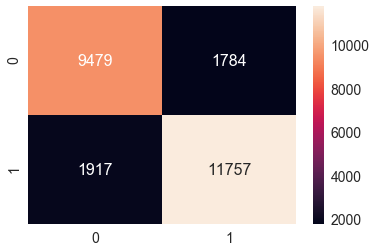

In [233]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [234]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.83      0.84      0.84     11263
   positive       0.87      0.86      0.86     13674

avg / total       0.85      0.85      0.85     24937



***ROC CURVE - TFIDF WORD2VEC - LOG REG***

24937
<class 'list'>
vectorized_sum_zero_array SHAPE :  (24937, 1, 300)
<class 'numpy.ndarray'>
TFIDF_LENGTH LENGHT:  24937
tfidf_length_sum: 
tfidf_length_sum SHAPE:  24937
tfidf_length_sum ELEMENT 0:  8.182331509388597

tfidf_length_sum ELEMENT 1:  7.272509661994287
averaged_array SHAPE:  (24937, 1, 300)
averaged_array_length LENGTH:  24937
averaged_array_reshape LENGTH:  24937
averaged_array_reshape SHAPE:  (24937, 300)


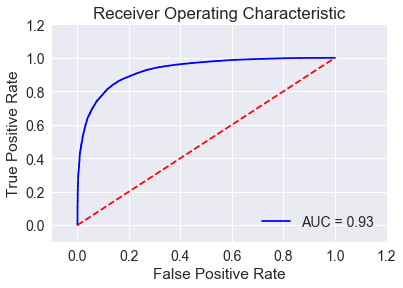

In [235]:
# Predict classes using bOW Log Reg 
pred_prob = model_tfidfw2v_logisticreg_random.predict_proba(X_test)
# Display first 5 predictions
pred_prob[:10]

#fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:, 1])
y_test[0:10]


y_test_binary=np.where(y_test=="positive",1,0)

#fpr, tpr, thresholds = roc_curve(y_test_NB,Y_score[:, 1])
fpr, tpr, thresholds = roc_curve(y_test_binary,pred_prob[:, 1])

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


***SUMMARY RESULTS***

In [236]:
# https://stackoverflow.com/questions/9535954/printing-lists-as-tabular-data

def print_table(table):
    longest_cols = [
        (max([len(str(row[i])) for row in table]) + 3)
        for i in range(len(table[0]))
    ]
    row_format = "".join(["{:>" + str(longest_col) + "}" for longest_col in longest_cols])
    for row in table:
        print(row_format.format(*row))

table = [
    ["Model", "BEST PENALTY","BEST C", "BEST_CV_SCORE", "TEST_ACCURACY"],
    ["BOW-Model-Grid Search",model_bow_logisticreg.best_params_['logisticreg__penalty'],model_bow_logisticreg.best_params_['logisticreg__C'], model_bow_logisticreg.best_score_, round(test_accuracy_bow_grid,2)],
    
	["BOW-Model-Random Search",model_bow_logisticreg_random.best_params_['logisticreg__penalty'],model_bow_logisticreg_random.best_params_['logisticreg__C'], model_bow_logisticreg_random.best_score_, round(test_accuracy_bow_random,2)],
	
	["TFIDF-Model-Grid Search",model_tfidf_logisticreg.best_params_['logisticreg__penalty'],model_tfidf_logisticreg.best_params_['logisticreg__C'], model_tfidf_logisticreg.best_score_, round(test_accuracy_tfidf_grid,2)],
    
	["TFIDF-Model-Random Search",model_tfidf_logisticreg_random.best_params_['logisticreg__penalty'],model_tfidf_logisticreg_random.best_params_['logisticreg__C'], model_tfidf_logisticreg_random.best_score_, round(test_accuracy_tfidf_random,2)],
	
	["AVG W2VEC-Model-Grid Search",model_avg_w2vec_logisticreg.best_params_['logisticreg__penalty'],model_avg_w2vec_logisticreg.best_params_['logisticreg__C'], model_avg_w2vec_logisticreg.best_score_, round(test_accuracy_avg_w2vec_grid,2)],
    
	["AVG W2VEC-Model-Random Search",model_avg_w2vec_logisticreg_random.best_params_['logisticreg__penalty'],model_avg_w2vec_logisticreg_random.best_params_['logisticreg__C'], model_avg_w2vec_logisticreg_random.best_score_, round(test_accuracy_avg_w2vec_random,2)],
	
	["TFIDF W2VEC-Model-Grid Search",model_tfidfw2v_logisticreg.best_params_['logisticreg__penalty'],model_tfidfw2v_logisticreg.best_params_['logisticreg__C'], model_tfidfw2v_logisticreg.best_score_, round(test_accuracy_tfidfw2v_grid,2)],
    
	["TFIDF W2VEC-Model-Random Search",model_tfidfw2v_logisticreg_random.best_params_['logisticreg__penalty'],model_tfidfw2v_logisticreg_random.best_params_['logisticreg__C'], model_tfidfw2v_logisticreg_random.best_score_, round(test_accuracy_tfidfw2v_random,2)]
]
 
print_table(table)

                             Model   BEST PENALTY   BEST C        BEST_CV_SCORE   TEST_ACCURACY
             BOW-Model-Grid Search             l2        5   0.8671112333287502           87.86
           BOW-Model-Random Search             l2        5   0.8671112333287502           87.86
           TFIDF-Model-Grid Search             l2     1000    0.883496035565333            89.5
         TFIDF-Model-Random Search             l2     1000    0.883496035565333            89.5
       AVG W2VEC-Model-Grid Search             l1     1000   0.8702506989321234           87.27
     AVG W2VEC-Model-Random Search             l1      500   0.8702506989321234           87.24
     TFIDF W2VEC-Model-Grid Search             l1      500   0.8485952610110454           85.19
   TFIDF W2VEC-Model-Random Search             l2     1000   0.8478848709840048           85.16


***CONCLUSION:-***

1) As per above TFIDF performed well with highest accuracy 89.5.
2) Regarding optimization Random search is very faster and gave same accuracy as compared to Grid Search. 
1) For L1 Regularizer,As C decreases(or Lambda increases), Sparsity increases.